In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
import scipy.stats as stats
pd.set_option('display.max_columns', None)

In [2]:
import warnings 
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch
from torch import nn 
import torch.nn.functional as F
from torch import utils

torch.manual_seed(0)
np.random.seed(0)

# Data preparation

## datasets integration

In [3]:
df_media = pd.read_csv('Media Investment.csv')
df_train = pd.read_csv('Sales by customer location train.csv')
df_store = pd.read_csv('Sales by store location.csv')
df_test = pd.read_csv('Sales by customer location test.csv')
df_income = pd.read_csv('Total personal income (weekly) by state and territory(a), 2021 Census.csv', header =1)
df_train_test = pd.concat([df_train, df_test], axis=0)
df_train_test.reset_index(drop=True, inplace=True)

In [4]:
df_train_test

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value,financial_week_end_date
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,Budget-New Families,51,77,6691.29,6146.98,1545.78,2023-03-26
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,331.40,89.72,2022-01-02
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,Mainstream-Young Singles/Couples,10,11,446.25,405.69,9.75,2023-03-19
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,Mainstream-Young Families,79,119,7479.89,6817.90,1365.50,2023-01-29
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Premium-New Families,58,84,6172.44,5630.27,508.59,2021-11-07
...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,Mainstream-Retirees,166,226,15227.36,14120.76,1619.65,2021-12-19
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,Premium-New Families,13,16,1210.86,1100.79,144.25,2023-04-02
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,Mainstream-New Families,44,57,3031.11,2757.60,376.65,2022-03-06
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Budget-Young Singles/Couples,142,221,8690.64,7904.23,2018.38,2023-03-05


In [5]:
df_train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193110 entries, 0 to 2193109
Data columns (total 11 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   store_id                       object 
 1   sales_channel                  object 
 2   customer_state                 object 
 3   customer_postcode              float64
 4   price_lifestage_segment        object 
 5   customer_count                 int64  
 6   transaction_count              int64  
 7   total_sale_value               float64
 8   total_sale_value_ex_gst        float64
 9   total_promotional_sales_value  float64
 10  financial_week_end_date        object 
dtypes: float64(4), int64(2), object(5)
memory usage: 184.1+ MB


In [6]:
df_store=df_store.rename(columns={'total_sale_value':'store_total_sale_value'
                         ,'total_sale_value_ex_gst': 'store_total_sale_value_ex_gst'
                         ,'total_promotional_sales_value':'store_total_promotional_sales_value'})

df_store = df_store.drop_duplicates(subset=['store_id', 'sales_channel']
                                        ,keep = 'first'
                                       )

df_train_test = pd.merge(df_train_test,df_store
             ,how ='left'
             ,on = ['store_id','sales_channel'])
df_train_test

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,Budget-New Families,51,77,6691.29,6146.98,1545.78,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,331.40,89.72,2022-01-02,VIC,3220,-38.1467,144.3587,NaN,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,Mainstream-Young Singles/Couples,10,11,446.25,405.69,9.75,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,Mainstream-Young Families,79,119,7479.89,6817.90,1365.50,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Premium-New Families,58,84,6172.44,5630.27,508.59,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,Mainstream-Retirees,166,226,15227.36,14120.76,1619.65,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,Premium-New Families,13,16,1210.86,1100.79,144.25,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,Mainstream-New Families,44,57,3031.11,2757.60,376.65,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Budget-Young Singles/Couples,142,221,8690.64,7904.23,2018.38,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92


In [7]:
df_media = df_media[df_media['state'] != 'UNKNOWN']
df_media.loc[df_media['state'] == 'National', 'media_amount_spend'] /= 8
df_media['media_amount_spend'] = df_media['media_amount_spend'].round().astype(int)

df_media['week_ending'] = pd.to_datetime(df_media['week_ending'], format='%d/%m/%Y')


In [8]:
df_train_test['financial_week_end_date'] = pd.to_datetime(df_train_test['financial_week_end_date'], format = '%Y-%m-%d')

df_train_test = pd.merge(df_train_test,df_media
             ,how ='left'
             ,left_on = ['financial_week_end_date','store_state']
             ,right_on = ['week_ending','state'])
df_train_test = df_train_test.drop(['week_ending','state'],axis = 1)

In [9]:
df_income= df_income.iloc[:8,:2]
df_income = df_income.rename(columns={'Unnamed: 0': 'store_state','Median income': 'state_median_income'})
df_income['store_state'] = df_income['store_state'].replace({'New South Wales': 'NSW'
                                                            ,'Victoria':'VIC'
                                                            ,'Queensland':'QLD'
                                                            ,'South Australia':'SA'
                                                            ,'Western Australia':'WA'
                                                            ,'Tasmania':'TAS'
                                                            ,'Northern Territory':'NT'
                                                            ,'Australian Capital Territory':'ACT'})
df_train_test = pd.merge(df_train_test,df_income
             ,how ='left'
             ,on = ['store_state'])
df_train_test

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,Budget-New Families,51,77,6691.29,6146.98,1545.78,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,NaN,813
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,331.40,89.72,2022-01-02,VIC,3220,-38.1467,144.3587,NaN,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,Mainstream-Young Singles/Couples,10,11,446.25,405.69,9.75,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,NaN,787
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,Mainstream-Young Families,79,119,7479.89,6817.90,1365.50,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Premium-New Families,58,84,6172.44,5630.27,508.59,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,Mainstream-Retirees,166,226,15227.36,14120.76,1619.65,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,Premium-New Families,13,16,1210.86,1100.79,144.25,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,NaN,848
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,Mainstream-New Families,44,57,3031.11,2757.60,376.65,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203"
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Budget-Young Singles/Couples,142,221,8690.64,7904.23,2018.38,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803


# Missing Values processing

In [10]:
df_train_test.isnull().sum() 

store_id                                    0
sales_channel                               0
customer_state                              0
customer_postcode                           8
price_lifestage_segment                 16210
customer_count                              0
transaction_count                           0
total_sale_value                            0
total_sale_value_ex_gst                     0
total_promotional_sales_value               0
financial_week_end_date                     0
store_state                                 0
store_postcode                              0
store_latitude                              0
store_longitude                             0
co_location_flag                        47393
distance_to_kmart                           0
distance_to_target                          0
store_total_sale_value                      0
store_total_sale_value_ex_gst               0
store_total_promotional_sales_value         0
media_amount_spend                

##  postcode

In [11]:
missing_postcode = df_train_test[df_train_test['customer_postcode'].isnull()] # begin with nulls in postcode

In [12]:
missing_postcode # customer_state indicating Other is also strange

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income
10212,c2c49462eba817d37eb58cc8203802b4,Store,Other,NaN,Premium-Young Singles/Couples,7,7,272.38,247.61,92.97,2021-12-19,VIC,3000,-37.8113,144.9648,True,<1 KM,>5 KM,55647418.18,50797639.01,6446419.32,278453.0,803
311002,c2c49462eba817d37eb58cc8203802b4,Store,Other,NaN,Premium-Young Singles/Couples,6,7,291.05,264.59,35.30,2023-01-01,VIC,3000,-37.8113,144.9648,True,<1 KM,>5 KM,55647418.18,50797639.01,6446419.32,1008759.0,803
902635,c2c49462eba817d37eb58cc8203802b4,Store,Other,NaN,Premium-Young Singles/Couples,7,7,165.65,150.83,11.20,2022-09-25,VIC,3000,-37.8113,144.9648,True,<1 KM,>5 KM,55647418.18,50797639.01,6446419.32,84888.0,803
918724,83822f5159c98d493a11ffbcd05df7f9,Store,Other,NaN,Budget-Young Families,7,9,429.20,390.18,101.10,2023-05-14,VIC,3810,-38.0763,145.4836,True,>5 KM,>5 KM,56737429.74,51742648.49,7174283.16,NaN,803
1314718,be30a998b7393750806a3058d926469f,Store,Other,NaN,Premium-Young Families,6,8,402.90,368.82,6.00,2022-10-23,NSW,2100,-33.7677,151.2657,True,Same Centre,>5 KM,64984615.50,59241829.06,8499786.13,347227.0,813
1357169,c2c49462eba817d37eb58cc8203802b4,Store,Other,NaN,Mainstream-Young Singles/Couples,7,8,173.28,158.05,6.95,2022-12-25,VIC,3000,-37.8113,144.9648,True,<1 KM,>5 KM,55647418.18,50797639.01,6446419.32,181532.0,803
1641168,c2c49462eba817d37eb58cc8203802b4,Store,Other,NaN,Premium-Young Singles/Couples,6,6,151.75,137.96,3.10,2023-01-15,VIC,3000,-37.8113,144.9648,True,<1 KM,>5 KM,55647418.18,50797639.01,6446419.32,273360.0,803
2111845,c2c49462eba817d37eb58cc8203802b4,Store,Other,NaN,Mainstream-Young Singles/Couples,6,6,1013.05,921.64,4.10,2023-02-05,VIC,3000,-37.8113,144.9648,True,<1 KM,>5 KM,55647418.18,50797639.01,6446419.32,1285849.0,803


In [13]:
df_train_test['customer_state'].value_counts() # 'Other' should be handled together with postcode missing values

NSW      664338
QLD      567827
VIC      353196
WA       242199
SA       222653
ACT       66131
TAS       50221
NT        26537
Other         8
Name: customer_state, dtype: int64

In [14]:
missing_postcode['store_id'].value_counts() # the same store id could show similar customer location information

c2c49462eba817d37eb58cc8203802b4    6
83822f5159c98d493a11ffbcd05df7f9    1
be30a998b7393750806a3058d926469f    1
Name: store_id, dtype: int64

In [15]:
store_ids_filter_1 = ['c2c49462eba817d37eb58cc8203802b4']
store_ids_filter_2 = ['83822f5159c98d493a11ffbcd05df7f9']
store_ids_filter_3 = ['be30a998b7393750806a3058d926469f']
filtered_rows1 = df_train_test[df_train_test['store_id'].isin(store_ids_filter_1)]
filtered_rows2 = df_train_test[df_train_test['store_id'].isin(store_ids_filter_2)]
filtered_rows3 = df_train_test[df_train_test['store_id'].isin(store_ids_filter_3)]
# filter these stores' information, one store shall appear overwhelmingly more frequently than the miss values.

In [16]:
columns_to_keep = ['store_id', 'customer_state', 'customer_postcode']

filtered_rows1 = filtered_rows1.loc[:, columns_to_keep]
filtered_rows2 = filtered_rows2.loc[:, columns_to_keep]
filtered_rows3 = filtered_rows3.loc[:, columns_to_keep]
# keep only the related columns

In [17]:
filtered_rows1['customer_state'].value_counts() #Vic most proba, the customer is from VIC with minor chances purchasing in other states 

VIC      10485
Other        6
QLD          5
TAS          2
Name: customer_state, dtype: int64

In [18]:
filtered_rows1['customer_postcode'].value_counts().head() #using the most freq value

3000.0    1716
3006.0    1055
3008.0     892
3053.0     867
3051.0     634
Name: customer_postcode, dtype: int64

In [19]:
filtered_rows2['customer_state'].value_counts()

VIC      10641
Other        1
Name: customer_state, dtype: int64

In [20]:
filtered_rows2['customer_postcode'].value_counts().head()# same reasonales

3810.0    2328
3809.0    1631
3981.0     923
3818.0     760
3977.0     729
Name: customer_postcode, dtype: int64

In [21]:
filtered_rows3['customer_state'].value_counts()

NSW      18287
Other        1
Name: customer_state, dtype: int64

In [22]:
filtered_rows3['customer_postcode'].value_counts().head() # all the top2 freq postcodes are close to each other 

2099.0    1997
2100.0    1765
2093.0    1444
2097.0    1361
2086.0    1310
Name: customer_postcode, dtype: int64

In [23]:
#imput the missing values in postcode and customer state
fill_values = {
    'c2c49462eba817d37eb58cc8203802b4': {'customer_state': 'VIC', 'customer_postcode': 3000.0},
    '83822f5159c98d493a11ffbcd05df7f9': {'customer_state': 'VIC', 'customer_postcode': 3810.0},
    'be30a998b7393750806a3058d926469f': {'customer_state': 'NSW', 'customer_postcode': 2099.0},
}

for store_id, values in fill_values.items():
    df_train_test.loc[df_train_test['store_id'] == store_id, ['customer_state', 'customer_postcode']] = values.values()

In [24]:
df_train_test.isna().sum()

store_id                                    0
sales_channel                               0
customer_state                              0
customer_postcode                           0
price_lifestage_segment                 16210
customer_count                              0
transaction_count                           0
total_sale_value                            0
total_sale_value_ex_gst                     0
total_promotional_sales_value               0
financial_week_end_date                     0
store_state                                 0
store_postcode                              0
store_latitude                              0
store_longitude                             0
co_location_flag                        47393
distance_to_kmart                           0
distance_to_target                          0
store_total_sale_value                      0
store_total_sale_value_ex_gst               0
store_total_promotional_sales_value         0
media_amount_spend                

## price_lifestage_segment

In [25]:
df_train_test['price_lifestage_segment'].value_counts()

Budget-Young Families                195153
Mainstream-Older Singles/Couples     166243
Mainstream-Young Families            160767
Budget-Older Singles/Couples         138146
Mainstream-Retirees                  133369
Mainstream-Young Singles/Couples     117011
Premium-Older Singles/Couples        115552
Premium-Young Families               104866
Budget-Older Families                103010
Budget-New Families                  101359
Budget-Young Singles/Couples         100759
Budget-Retirees                       94618
Premium-Retirees                      92081
Mainstream-New Families               91410
Mainstream-Older Families             91070
Mainstream-Midage Singles/Couples     79758
Budget-Midage Singles/Couples         66062
Premium-Young Singles/Couples         62842
Premium-Midage Singles/Couples        60013
Premium-New Families                  58197
Premium-Older Families                44614
Name: price_lifestage_segment, dtype: int64

In [26]:
missing_p_l_s_seg = df_train_test[df_train_test['price_lifestage_segment'].isnull()] # handle missing values in price_lifestage_segment

In [27]:
#missing_p_l_s_seg['customer_count'].describe() 

In [28]:
#missing_p_l_s_seg['transaction_count'].describe()

In [29]:
missing_p_l_s_seg['total_sale_value'].describe()# distribution of missing value is more central and 
#representative on total_sale_value, so the most similar groupedby customer segement in the whole dataset will be imputed to the nulls

count    16210.000000
mean       897.813128
std        731.368031
min         48.100000
25%        424.900000
50%        678.800000
75%       1118.512500
max       9100.510000
Name: total_sale_value, dtype: float64

In [30]:
missing_p_l_s_seg['total_sale_value'].median()#skewed, median preferred.

678.8

In [31]:
customer_median = df_train_test.groupby('price_lifestage_segment')['total_sale_value'].median().reset_index().sort_values(by = 'total_sale_value', ascending= True)

In [32]:
customer_median.head(10) # Budget-Retirees is the closest to the missing values

,price_lifestage_segment,total_sale_value
20,Premium-Young Singles/Couples,522.750
14,Premium-Midage Singles/Couples,590.600
18,Premium-Retirees,657.730
16,Premium-Older Families,674.135
4,Budget-Retirees,677.020
13,Mainstream-Young Singles/Couples,687.700
7,Mainstream-Midage Singles/Couples,723.220
15,Premium-New Families,747.620
17,Premium-Older Singles/Couples,751.735
11,Mainstream-Retirees,770.350


In [33]:
# it is reasonable the missing values appear in the older groups.

In [34]:
fill_values1 = {
    'price_lifestage_segment': 'Budget-Retirees'
}
df_train_test.fillna(fill_values1, inplace=True)

In [35]:
df_train_test.isna().sum()

store_id                                    0
sales_channel                               0
customer_state                              0
customer_postcode                           0
price_lifestage_segment                     0
customer_count                              0
transaction_count                           0
total_sale_value                            0
total_sale_value_ex_gst                     0
total_promotional_sales_value               0
financial_week_end_date                     0
store_state                                 0
store_postcode                              0
store_latitude                              0
store_longitude                             0
co_location_flag                        47393
distance_to_kmart                           0
distance_to_target                          0
store_total_sale_value                      0
store_total_sale_value_ex_gst               0
store_total_promotional_sales_value         0
media_amount_spend                

In [36]:
columns_to_drop = ['total_sale_value_ex_gst']

# Drop the specified columns, location features will be analysed in the sales_location dataset
df_train_test.drop(columns=columns_to_drop, inplace=True)

In [37]:
df_train_test

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,Budget-New Families,51,77,6691.29,1545.78,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,NaN,813
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,89.72,2022-01-02,VIC,3220,-38.1467,144.3587,NaN,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,Mainstream-Young Singles/Couples,10,11,446.25,9.75,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,NaN,787
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,Mainstream-Young Families,79,119,7479.89,1365.50,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Premium-New Families,58,84,6172.44,508.59,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,Mainstream-Retirees,166,226,15227.36,1619.65,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,Premium-New Families,13,16,1210.86,144.25,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,NaN,848
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,Mainstream-New Families,44,57,3031.11,376.65,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203"
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Budget-Young Singles/Couples,142,221,8690.64,2018.38,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803


## co_location_flag

In [38]:
missing_co_loc_flag = df_train_test[df_train_test['co_location_flag'].isnull()]
missing_co_loc_flag # the nan value indicates that the there is a big w store occupying a whole archeteture

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,89.72,2022-01-02,VIC,3220,-38.1467,144.3587,NaN,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803
249,f0f4b6598f2cee45644673998b4f44be,Store,ACT,2612.0,Premium-Young Singles/Couples,50,56,2232.66,498.52,2022-12-25,ACT,2601,-35.2805,149.1342,NaN,>5 KM,>5 KM,41291005.34,37694650.17,5614321.26,10679.0,"1,203"
280,f0f4b6598f2cee45644673998b4f44be,Store,ACT,2913.0,Budget-Young Families,12,14,513.64,59.62,2022-07-31,ACT,2601,-35.2805,149.1342,NaN,>5 KM,>5 KM,41291005.34,37694650.17,5614321.26,5051.0,"1,203"
295,62a8d042a93d5f88fb6636cde700ce69,Store,QLD,4305.0,Budget-New Families,27,37,3196.69,582.86,2022-04-17,QLD,4301,-27.6056,152.8679,NaN,Same Centre,3-5 KM,36425237.61,33316320.88,5254754.30,203068.0,787
357,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3212.0,Premium-Retirees,6,6,358.98,0.00,2022-10-23,VIC,3220,-38.1467,144.3587,NaN,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,261046.0,803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192965,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3219.0,Mainstream-Retirees,33,37,1121.00,58.95,2022-10-30,VIC,3220,-38.1467,144.3587,NaN,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,183356.0,803
2192969,de7a8f7c083abf41a583073d8704ea72,Store,VIC,3029.0,Budget-Young Singles/Couples,9,12,402.85,82.90,2023-03-05,VIC,3028,-37.8716,144.7772,NaN,3-5 KM,3-5 KM,33158392.97,30283329.30,5016487.64,60130.0,803
2192970,62a8d042a93d5f88fb6636cde700ce69,Store,QLD,4301.0,Mainstream-Midage Singles/Couples,22,24,1315.45,242.95,2022-08-07,QLD,4301,-27.6056,152.8679,NaN,Same Centre,3-5 KM,36425237.61,33316320.88,5254754.30,1293663.0,787
2193032,f0f4b6598f2cee45644673998b4f44be,Store,ACT,2602.0,Premium-New Families,20,23,1129.06,47.20,2022-05-01,ACT,2601,-35.2805,149.1342,NaN,>5 KM,>5 KM,41291005.34,37694650.17,5614321.26,6953.0,"1,203"


In [39]:
df_train_test['co_location_flag'].fillna(False, inplace=True)
df_train_test['distance_to_kmart'].fillna('>5 KM', inplace=True)
missing_target_dis = df_train_test[df_train_test['distance_to_target'].isnull()]
df_train_test['distance_to_target'].fillna('>5 KM', inplace=True)
df_train_test.isna().sum()

store_id                                    0
sales_channel                               0
customer_state                              0
customer_postcode                           0
price_lifestage_segment                     0
customer_count                              0
transaction_count                           0
total_sale_value                            0
total_promotional_sales_value               0
financial_week_end_date                     0
store_state                                 0
store_postcode                              0
store_latitude                              0
store_longitude                             0
co_location_flag                            0
distance_to_kmart                           0
distance_to_target                          0
store_total_sale_value                      0
store_total_sale_value_ex_gst               0
store_total_promotional_sales_value         0
media_amount_spend                     239703
state_median_income               

## media_amount_spend

In [40]:
df_train_test['media_amount_spend'].fillna(0, inplace=True)
df_train_test.isna().sum()

store_id                               0
sales_channel                          0
customer_state                         0
customer_postcode                      0
price_lifestage_segment                0
customer_count                         0
transaction_count                      0
total_sale_value                       0
total_promotional_sales_value          0
financial_week_end_date                0
store_state                            0
store_postcode                         0
store_latitude                         0
store_longitude                        0
co_location_flag                       0
distance_to_kmart                      0
distance_to_target                     0
store_total_sale_value                 0
store_total_sale_value_ex_gst          0
store_total_promotional_sales_value    0
media_amount_spend                     0
state_median_income                    0
dtype: int64

In [41]:
df_train_test_cleaned = df_train_test
df_train_test_cleaned

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,Budget-New Families,51,77,6691.29,1545.78,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,0.0,813
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,89.72,2022-01-02,VIC,3220,-38.1467,144.3587,False,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,Mainstream-Young Singles/Couples,10,11,446.25,9.75,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,0.0,787
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,Mainstream-Young Families,79,119,7479.89,1365.50,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Premium-New Families,58,84,6172.44,508.59,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,Mainstream-Retirees,166,226,15227.36,1619.65,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,Premium-New Families,13,16,1210.86,144.25,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,0.0,848
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,Mainstream-New Families,44,57,3031.11,376.65,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203"
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Budget-Young Singles/Couples,142,221,8690.64,2018.38,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803


# EDA

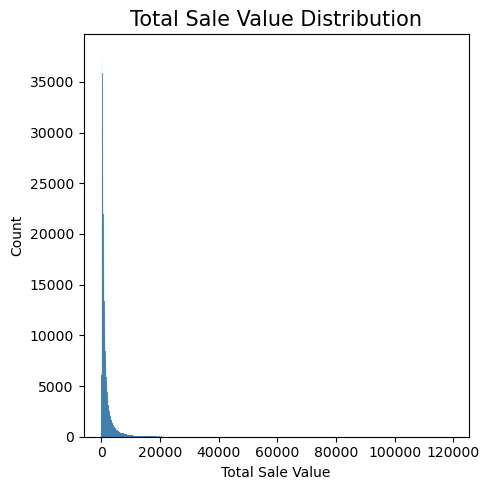

In [42]:
plt.figure(figsize=(5,5)) # the figure is hard to interpret and the skewness is too high
sns.histplot(data=df_train_test,x='total_sale_value')
plt.title('Total Sale Value Distribution',fontsize=15)
plt.xlabel('Total Sale Value')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Total Sale Value Distribution.jpg',dpi=300)

In [43]:
df_train_test_cleaned['log_total_sale'] = np.log(df_train_test_cleaned['total_sale_value'])

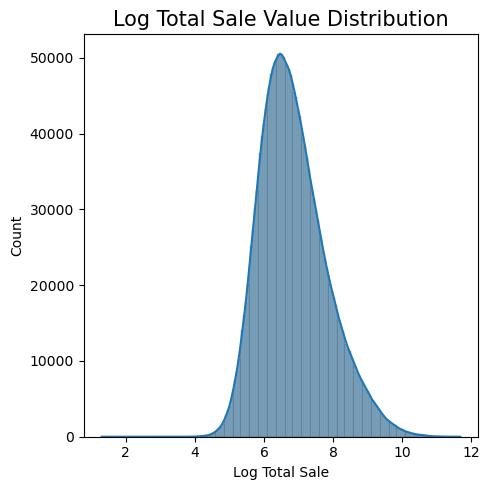

In [44]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df_train_test_cleaned, x='log_total_sale', bins=200, kde=True)  # Adjust the number of bins as needed
plt.title('Log Total Sale Value Distribution', fontsize=15)
plt.xlabel('Log Total Sale')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Log Total Sale Value Distribution.jpg',dpi=400)
# the log total sale distribution is much more a normal distribution

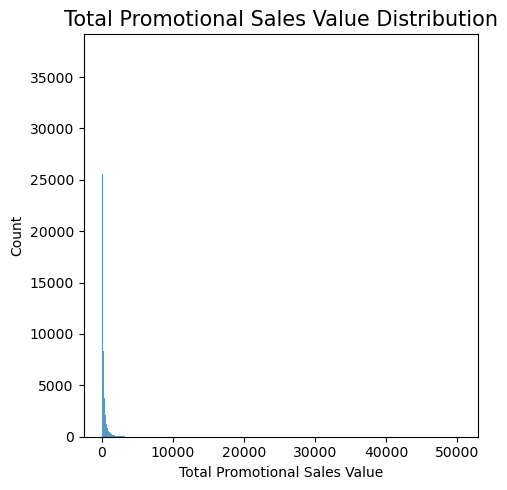

In [45]:
plt.figure(figsize=(5,5)) # the figure is hard to interpret and the skewness is too high
sns.histplot(data=df_train_test_cleaned,x='total_promotional_sales_value')
plt.title('Total Promotional Sales Value Distribution', fontsize=15)
plt.xlabel('Total Promotional Sales Value')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Total Promotional Sales Value Distribution.jpg',dpi=400)

In [46]:
df_train_test_cleaned['total_promotional_sales_value'].describe()

count    2.193110e+06
mean     2.573119e+02
std      4.963123e+02
min     -3.400000e+01
25%      5.280000e+01
50%      1.172500e+02
75%      2.642700e+02
max      5.040995e+04
Name: total_promotional_sales_value, dtype: float64

In [47]:
df_train_test_cleaned['total_promotional_sales_value'] += 1

In [48]:
df_train_test_cleaned['log_promotional_total_sale'] = np.log(df_train_test_cleaned['total_promotional_sales_value'])

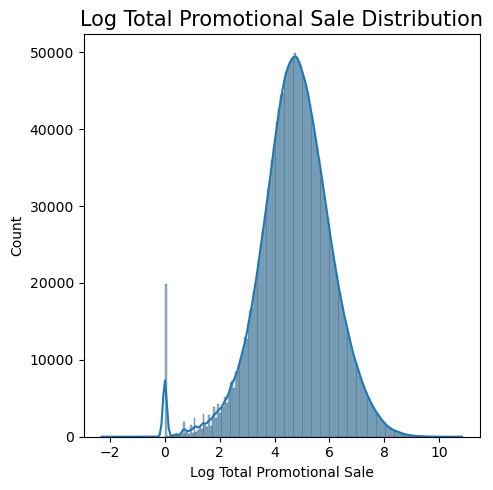

In [49]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df_train_test_cleaned, x='log_promotional_total_sale', bins=200, kde=True)  # Adjust the number of bins as needed
plt.title('Log Total Promotional Sale Distribution', fontsize=15)
plt.xlabel('Log Total Promotional Sale')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Log Total Promotional Sale Distribution.jpg',dpi=400)

In [50]:
df_train_test_cleaned

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income,log_total_sale,log_promotional_total_sale
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,Budget-New Families,51,77,6691.29,1546.78,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,0.0,813,8.808562,7.343931
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,90.72,2022-01-02,VIC,3220,-38.1467,144.3587,False,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803,5.898609,4.507778
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,Mainstream-Young Singles/Couples,10,11,446.25,10.75,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,0.0,787,6.100879,2.374906
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,Mainstream-Young Families,79,119,7479.89,1366.50,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734,8.919973,7.220008
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Premium-New Families,58,84,6172.44,509.59,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803,8.727850,6.233606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,Mainstream-Retirees,166,226,15227.36,1620.65,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813,9.630849,7.390583
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,Premium-New Families,13,16,1210.86,145.25,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,0.0,848,7.099086,4.978456
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,Mainstream-New Families,44,57,3031.11,377.65,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203",8.016684,5.933968
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Budget-Young Singles/Couples,142,221,8690.64,2019.38,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803,9.070002,7.610546


In [51]:
df_train_test_cleaned['log_total_sale']

0          8.808562
1          5.898609
2          6.100879
3          8.919973
4          8.727850
             ...   
2193105    9.630849
2193106    7.099086
2193107    8.016684
2193108    9.070002
2193109    6.553720
Name: log_total_sale, Length: 2193110, dtype: float64

In [52]:
# Calculate the average sale value by the distance to Kmart and Target
dtk_avgsale = df_store.groupby('distance_to_kmart')['store_total_sale_value'].mean().round(2).reset_index()
dtt_avgsale = df_store.groupby('distance_to_target')['store_total_sale_value'].mean().round(2).reset_index()

<Figure size 1600x800 with 0 Axes>

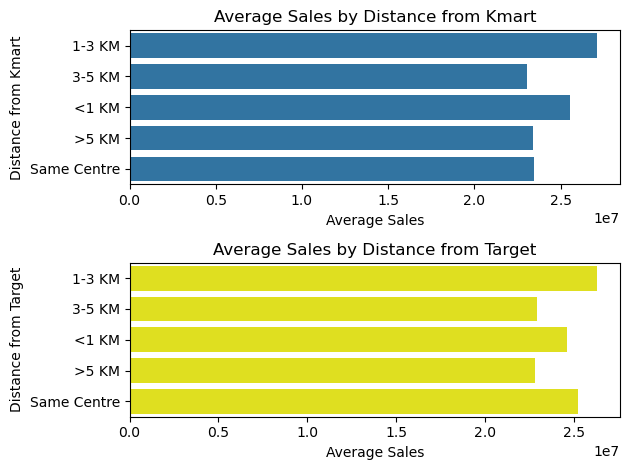

In [53]:
# Set plot size
plt.figure(figsize = (16, 8))

# Make subplots
fig, ax = plt.subplots(2, 1)
sns.barplot(data = dtk_avgsale, x = 'store_total_sale_value', y = 'distance_to_kmart', color = 'tab:blue', orient = 'h', ax = ax[0])
sns.barplot(data = dtt_avgsale, x = 'store_total_sale_value', y = 'distance_to_target', color = 'yellow', orient = 'h', ax = ax[1])

# Set title and labels for the subplots
ax[0].set_title('Average Sales by Distance from Kmart')
ax[0].set_xlabel('Average Sales')
ax[0].set_ylabel('Distance from Kmart')
ax[1].set_title('Average Sales by Distance from Target')
ax[1].set_xlabel('Average Sales')
ax[1].set_ylabel('Distance from Target')

# Set layout tight
fig.tight_layout()

# Feature correlations

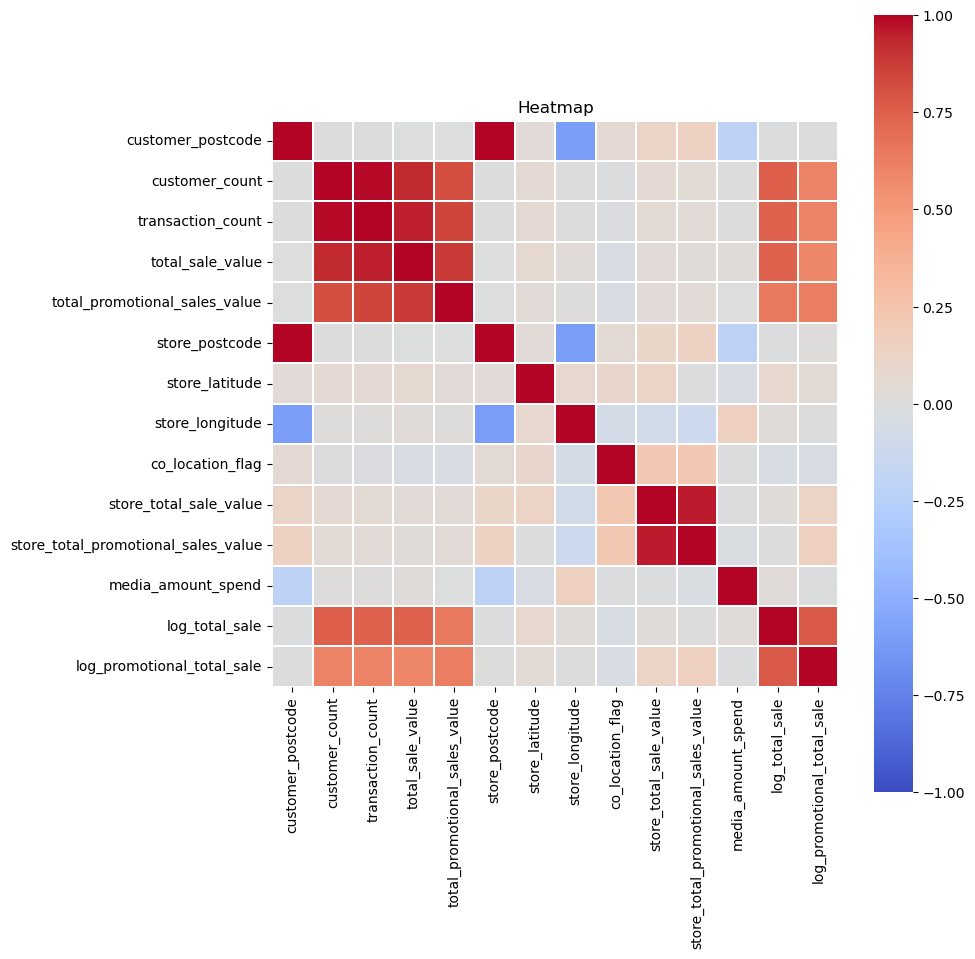

In [54]:
num_df = df_train_test_cleaned.select_dtypes(exclude='object').drop(['financial_week_end_date','store_total_sale_value_ex_gst'], axis =1)
cor = num_df.corr()
cor.iloc[:,2].sort_values(ascending = False)
fig = plt.figure(figsize =(10,10))

ax = sns.heatmap(cor, cmap='coolwarm', linewidths = .2,
                 square = True, vmax =1, vmin =-1)
plt.title('Heatmap')
plt.tight_layout()
plt.savefig('heat map.png',dpi =800)

# Quantitative to Quantitative relationship

In [56]:
# all the scatter plots show strong linear relationship
# features has high correlation with one of the above features will also have a potential high correlation to the others

# Categorical Features

In [57]:
df_train_test_cleaned['customer_state'].value_counts()

NSW    664339
QLD    567822
VIC    353210
WA     242199
SA     222653
ACT     66131
TAS     50219
NT      26537
Name: customer_state, dtype: int64

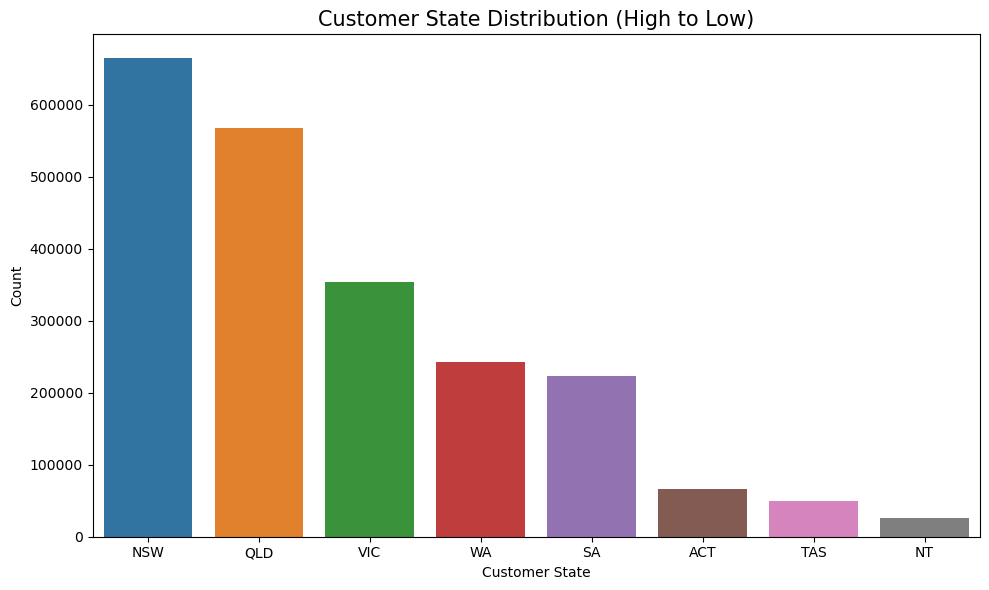

In [58]:
state_counts = df_train_test_cleaned['customer_state'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, order=state_counts.index)
plt.xlabel('Customer State')
plt.ylabel('Count')
plt.title('Customer State Distribution (High to Low)', fontsize=15)
plt.tight_layout()
plt.savefig('Customer State Distribution.jpg',dpi=400)

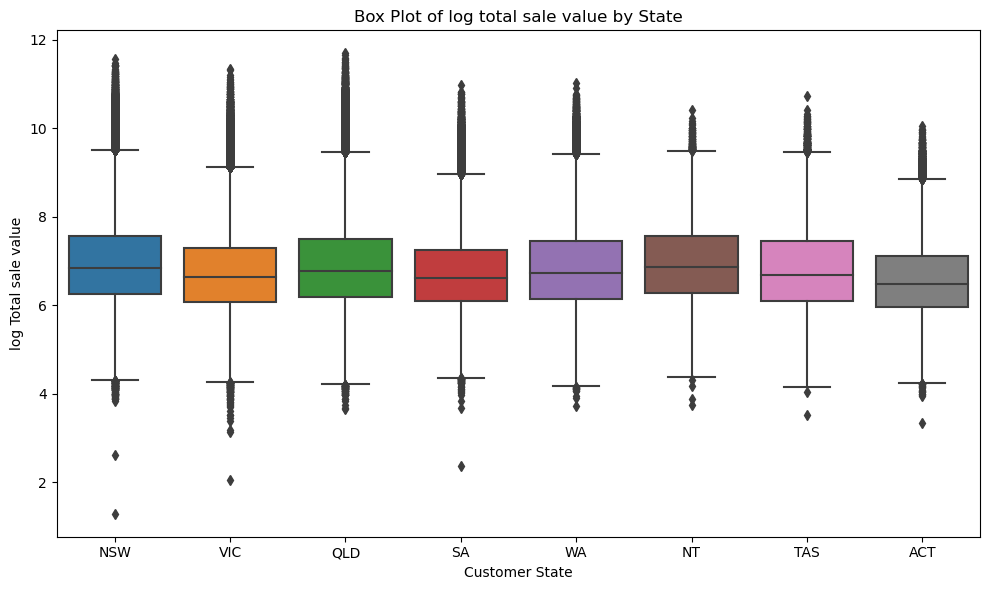

In [59]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Use seaborn to create a box plot
sns.boxplot(data=df_train_test_cleaned, x='customer_state', y='log_total_sale')

# Add labels and title
plt.xlabel('Customer State')
plt.ylabel('log Total sale value')
plt.title('Box Plot of log total sale value by State')

# Show the plot
plt.tight_layout()  # Ensure the labels fit within the figure
plt.show()
# where are high sale value from?

In [60]:
state_median_sales = df_train_test_cleaned.groupby('customer_state')['total_sale_value'].median().reset_index()

In [61]:
state_median_sales = state_median_sales.sort_values(by ='total_sale_value', ascending=False)

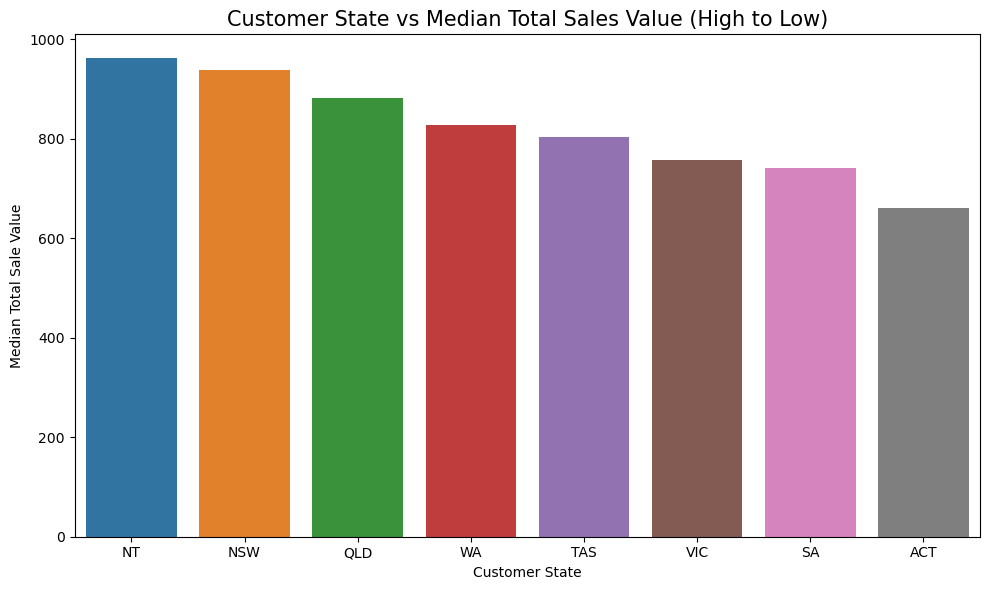

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(data=state_median_sales, x='customer_state', y='total_sale_value')
plt.xlabel('Customer State')
plt.ylabel('Median Total Sale Value')
plt.title('Customer State vs Median Total Sales Value (High to Low)', fontsize=15)
plt.tight_layout()
plt.savefig('Customer State vs Median Total Sales Value.jpg',dpi=400)

In [63]:
states_store_co = df_train_test_cleaned.groupby('store_state')['store_id'].nunique().sort_values(ascending = False)
states_sale = df_train_test_cleaned.groupby('store_state').sum()['total_sale_value'].sort_values(ascending= False)
state_sale_mean = df_train_test_cleaned.groupby('store_state').mean()['total_sale_value'].sort_values(ascending= False)
states_df = pd.merge(states_store_co,state_sale_mean
             ,how ='left'
             ,on = ['store_state']).reset_index()
states_df = states_df.rename(columns= {'store_id':'amount','total_sale_value':'mean_sale_value'})
states_df


,store_state,amount,mean_sale_value
0,NSW,58,1914.912126
1,QLD,46,1830.994583
2,VIC,29,1416.340315
3,SA,17,1345.484258
4,WA,17,1619.755649
5,ACT,5,1073.923722
6,TAS,3,1468.755909
7,NT,2,1642.596603


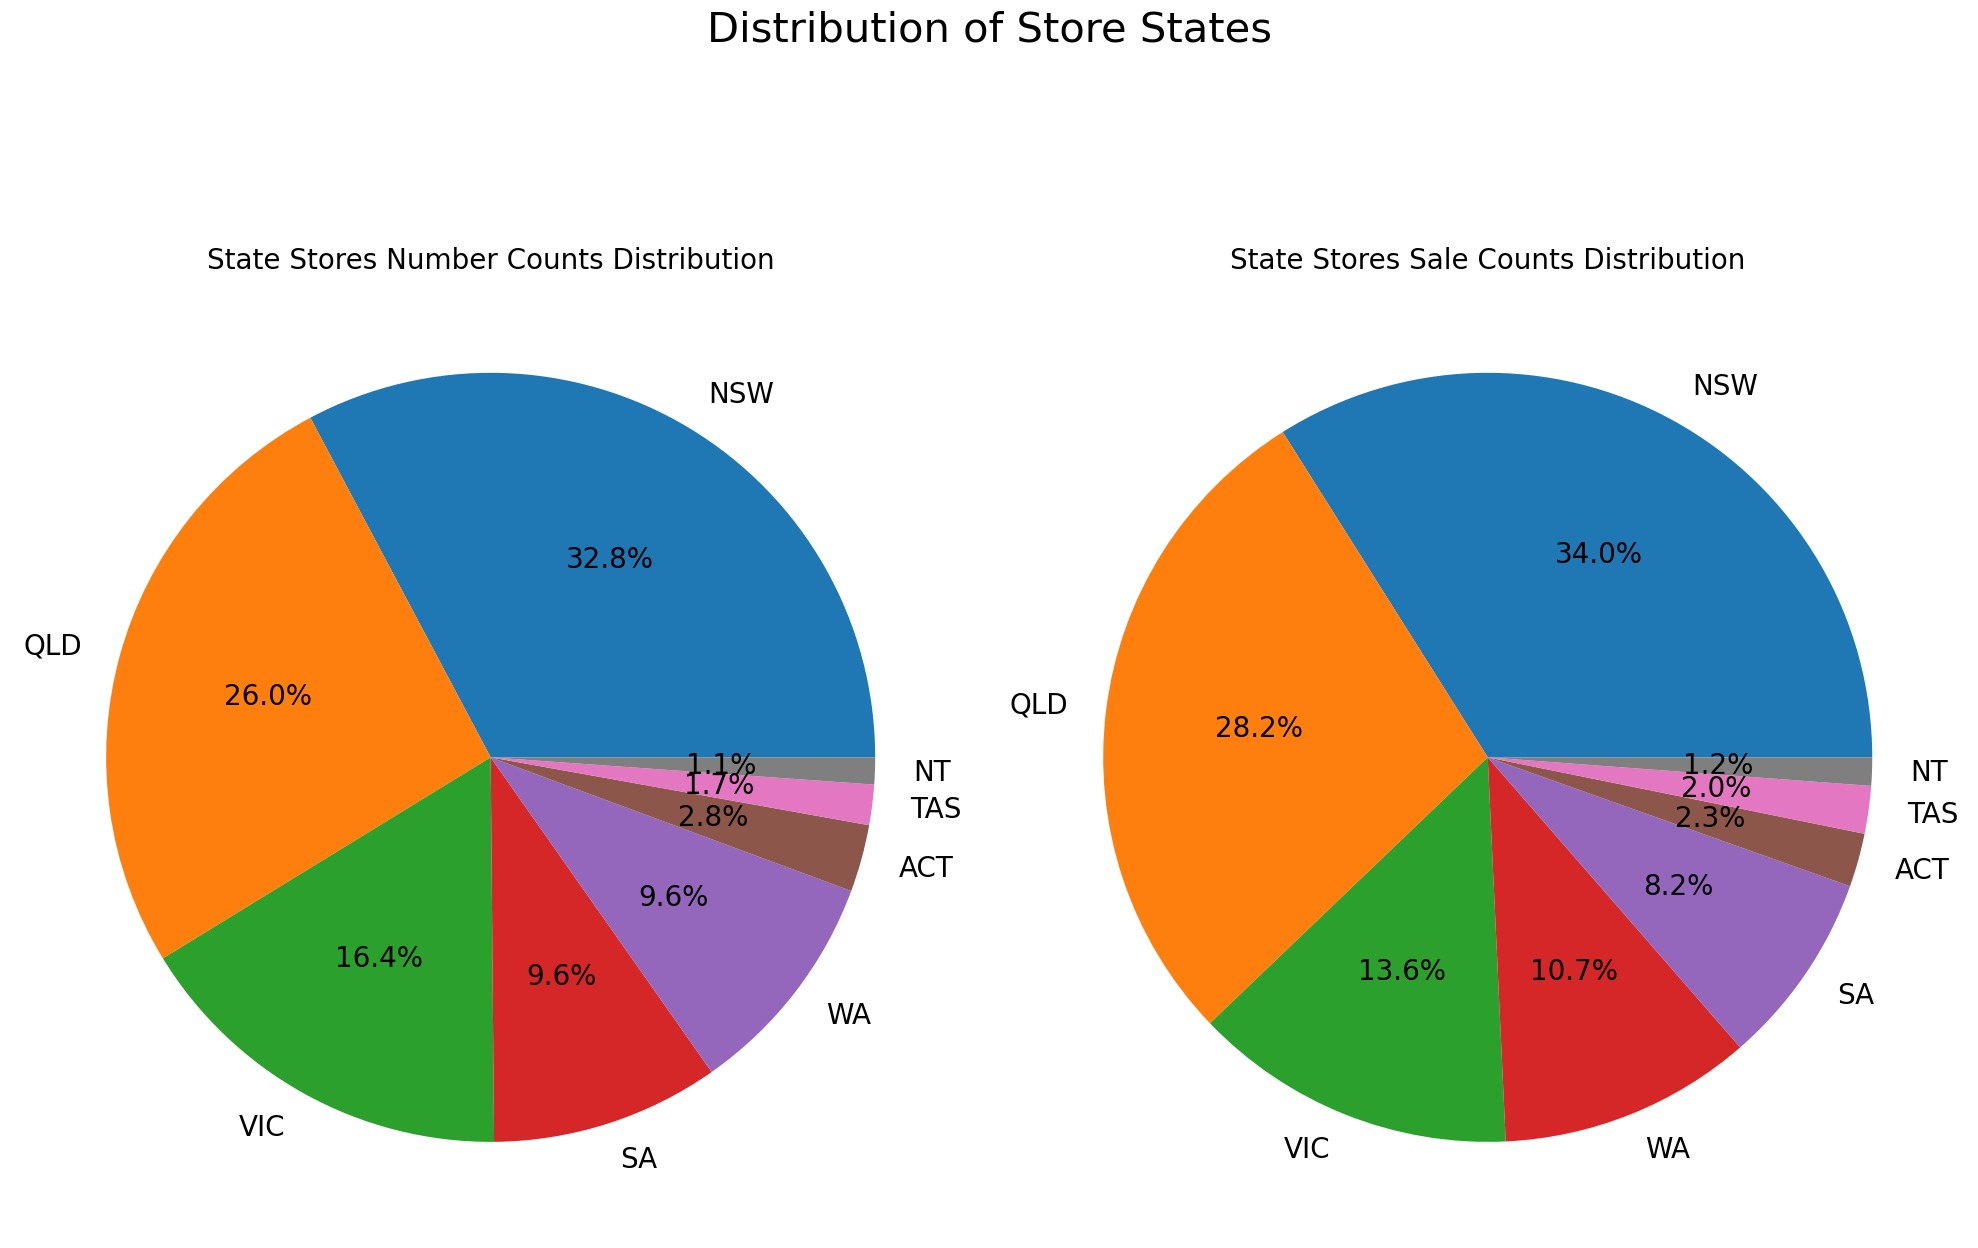

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =(20,15))

# store amount
ax[0].pie(states_store_co.values,labels=states_store_co.index ,autopct='%1.1f%%',textprops={'fontsize': 20})
ax[0].set_title('State Stores Number Counts Distribution',fontsize=20)

# sale amount
ax[1].pie(states_sale.values, labels=states_sale.index,autopct='%1.1f%%',textprops={'fontsize': 20})
ax[1].set_title('State Stores Sale Counts Distribution',fontsize=20)


fig.suptitle('Distribution of Store States', fontsize=30)
plt.tight_layout()
plt.savefig('st pie.png',dpi = 300)
plt.show()

In [65]:
# Few customer come from the NT however their median purchasing power is impressive, possible strategy on opening
# stores in the NT and going on campaigns to attract customers
# VIC market should be highly focused on promotions to make people spend more based on its market portion

In [66]:
sales_channel_median = df_train_test_cleaned.groupby('sales_channel')['total_sale_value'].median().reset_index()

In [67]:
sales_channel_median = sales_channel_median.sort_values(by = 'total_sale_value', ascending=False)

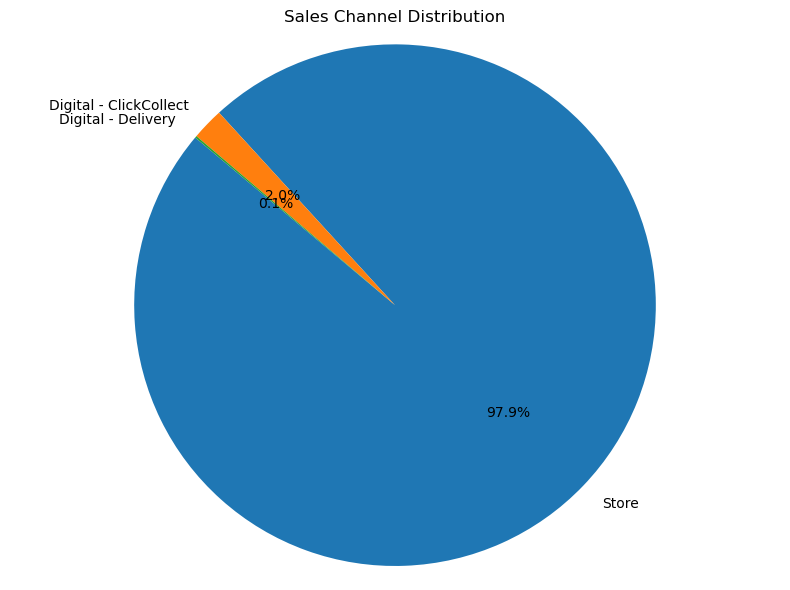

In [68]:
sales_channel_counts = df_train_test_cleaned['sales_channel'].value_counts()
labels = sales_channel_counts.index
values = sales_channel_counts.values

# Create a figure with a bit more space
plt.figure(figsize=(8, 6))

# Adjust the labeldistance to increase spacing between labels
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, labeldistance=1.1)

plt.title('Sales Channel Distribution')
plt.axis('equal')
plt.tight_layout()

# Save the figure
plt.savefig("sales_channel_pie_chart.png")
# needs combination

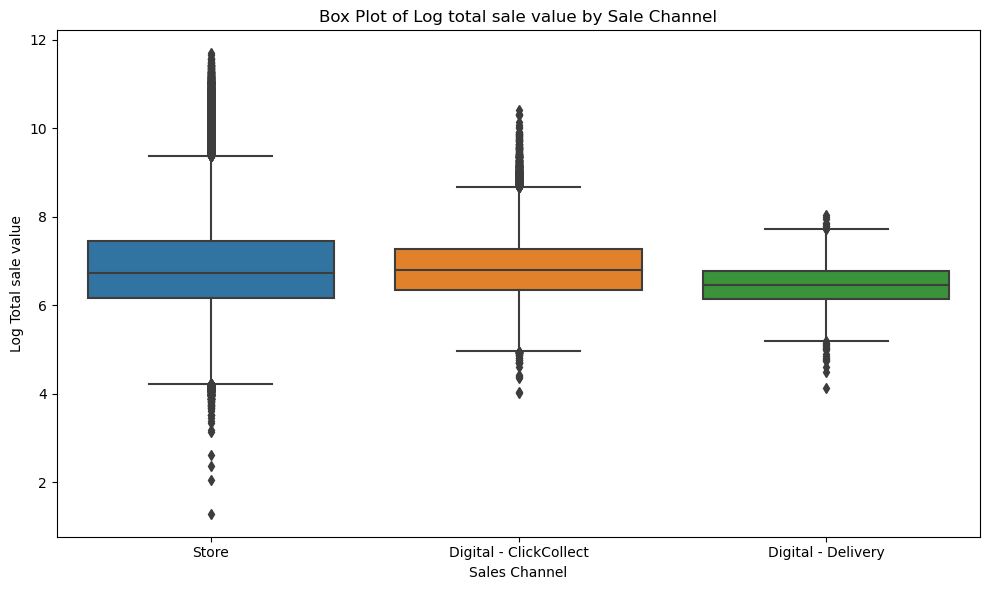

In [69]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Use seaborn to create a box plot
sns.boxplot(data=df_train_test_cleaned, x='sales_channel', y='log_total_sale')

# Add labels and title
plt.xlabel('Sales Channel')
plt.ylabel('Log Total sale value')
plt.title('Box Plot of Log total sale value by Sale Channel')

plt.tight_layout()  # Ensure the labels fit within the figure
plt.show()

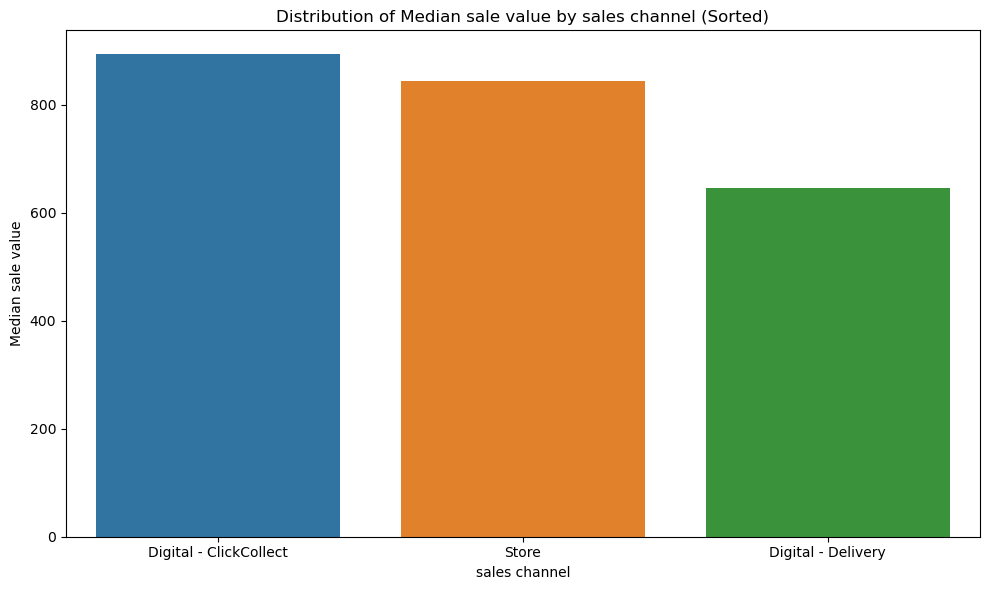

In [70]:
# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size

# Use seaborn to create a bar plot with the sorted order
sns.barplot(data=sales_channel_median, x='sales_channel', y='total_sale_value')

# Add labels and title
plt.xlabel('sales channel')
plt.ylabel('Median sale value')
plt.title('Distribution of Median sale value by sales channel (Sorted)')
plt.tight_layout()

# Save the figure
plt.savefig("Distribution of median sale value by sales channel.png")

# Show the plot
plt.show()
# which sales channel creates more value?

In [71]:
# the digital channel should be highly focused in the future, digital sales channel shows strong potential that 
# makes people buy more things online and collect themselves, the delivery channel showing low median sales value 
# may indicate customers are caring about the high delivery fees

In [72]:
# this column needs feature engineering
df_train_test_cleaned['sales_channel'] = df_train_test_cleaned['sales_channel'].replace(['Digital - ClickCollect', 'Digital - Delivery'], 'Digital')

In [73]:
df_train_test_cleaned

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income,log_total_sale,log_promotional_total_sale
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,Budget-New Families,51,77,6691.29,1546.78,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,0.0,813,8.808562,7.343931
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,Budget-Retirees,8,8,364.53,90.72,2022-01-02,VIC,3220,-38.1467,144.3587,False,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803,5.898609,4.507778
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,Mainstream-Young Singles/Couples,10,11,446.25,10.75,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,0.0,787,6.100879,2.374906
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,Mainstream-Young Families,79,119,7479.89,1366.50,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734,8.919973,7.220008
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Premium-New Families,58,84,6172.44,509.59,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803,8.727850,6.233606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,Mainstream-Retirees,166,226,15227.36,1620.65,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813,9.630849,7.390583
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,Premium-New Families,13,16,1210.86,145.25,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,0.0,848,7.099086,4.978456
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,Mainstream-New Families,44,57,3031.11,377.65,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203",8.016684,5.933968
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,Budget-Young Singles/Couples,142,221,8690.64,2019.38,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803,9.070002,7.610546


# time series related: promotion and sales

In [74]:
df_train_test_cleaned['financial_week_end_date'].sort_values()

976934    2021-07-04
1542396   2021-07-04
2106958   2021-07-04
1427942   2021-07-04
58381     2021-07-04
             ...    
238116    2023-05-21
1927801   2023-05-21
37252     2023-05-21
2059108   2023-05-21
109447    2023-05-21
Name: financial_week_end_date, Length: 2193110, dtype: datetime64[ns]

In [75]:
df_train_test_cleaned['financial_week_end_date'].describe()

count                 2193110
unique                     99
top       2022-12-25 00:00:00
freq                    34081
first     2021-07-04 00:00:00
last      2023-05-21 00:00:00
Name: financial_week_end_date, dtype: object

In [76]:
week_mean_sales = df_train_test_cleaned.groupby('financial_week_end_date')['total_sale_value'].mean().reset_index()

In [77]:
week_median_sales1 = df_train_test_cleaned.groupby('financial_week_end_date')['log_total_sale'].median().reset_index()

In [78]:
week_mean_sales

,financial_week_end_date,total_sale_value
0,2021-07-04,1531.503563
1,2021-07-11,1611.806955
2,2021-07-18,1644.606772
3,2021-07-25,1612.541663
4,2021-08-01,1586.272399
...,...,...
94,2023-04-23,1554.616898
95,2023-04-30,1548.676379
96,2023-05-07,1596.902269
97,2023-05-14,1686.989780


In [79]:
week_mean_promt = df_train_test_cleaned.groupby('financial_week_end_date')['total_promotional_sales_value'].mean().reset_index()

In [80]:
week_median_promt1 = df_train_test_cleaned.groupby('financial_week_end_date')['log_promotional_total_sale'].median().reset_index()

In [81]:
week_mean_promt

,financial_week_end_date,total_promotional_sales_value
0,2021-07-04,260.098354
1,2021-07-11,248.584648
2,2021-07-18,262.592711
3,2021-07-25,321.529464
4,2021-08-01,572.110668
...,...,...
94,2023-04-23,208.573942
95,2023-04-30,197.847905
96,2023-05-07,230.562871
97,2023-05-14,258.106255


In [83]:
time_sales = df_train_test_cleaned.groupby('financial_week_end_date')['total_sale_value'].sum().reset_index()
surges = time_sales[time_sales['total_sale_value'] >= time_sales['total_sale_value'].quantile(.9)]
surges

,financial_week_end_date,total_sale_value
21,2021-11-28,58999213.05
22,2021-12-05,59931985.56
23,2021-12-12,67764670.04
24,2021-12-19,77588997.98
25,2021-12-26,70329676.60
73,2022-11-27,60373278.47
74,2022-12-04,61252104.45
75,2022-12-11,69744869.21
76,2022-12-18,81396295.67
77,2022-12-25,85584595.22


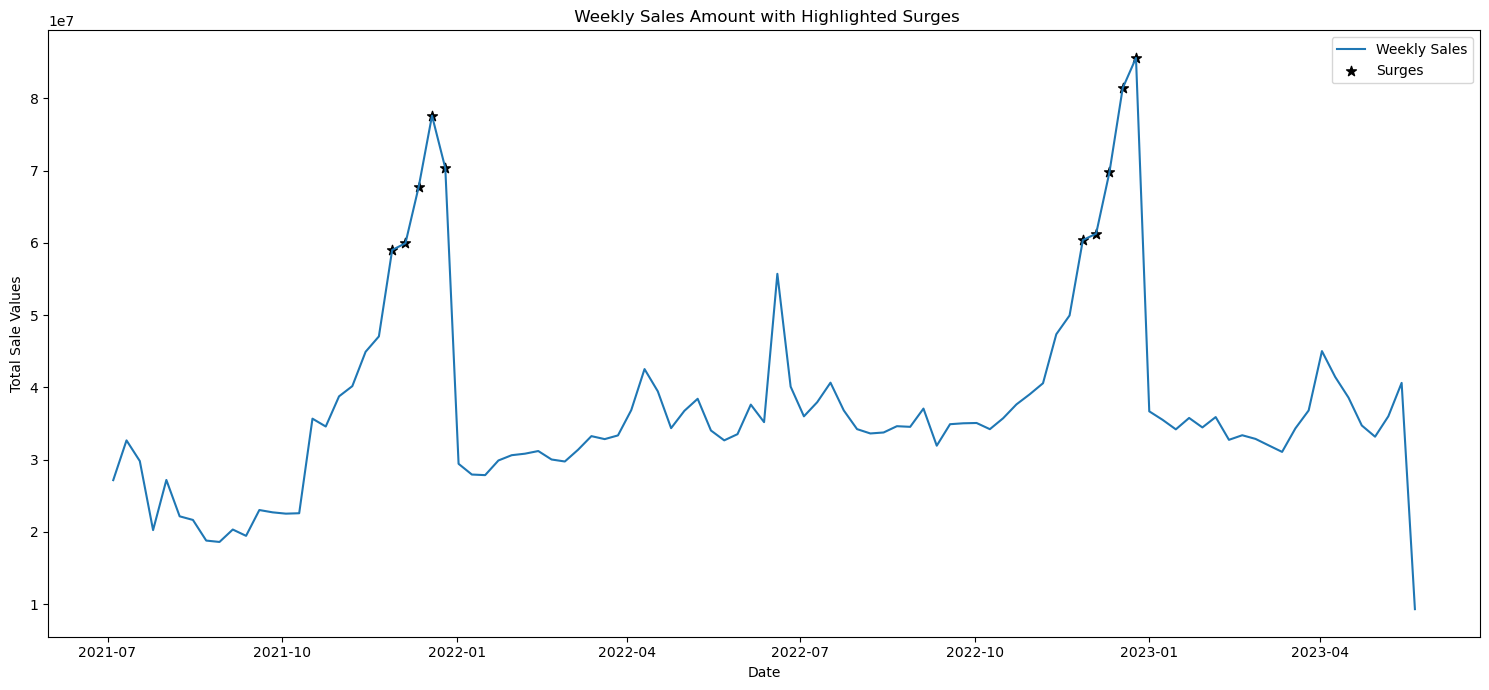

In [84]:
plt.figure(figsize=(15,7))
plt.plot(time_sales['financial_week_end_date'],time_sales['total_sale_value'], label ='Weekly Sales')
plt.scatter(surges['financial_week_end_date'],surges['total_sale_value'], marker ='*',color='black',label='Surges',s = 55)
plt.title(' Weekly Sales Amount with Highlighted Surges')
plt.xlabel('Date')
plt.ylabel('Total Sale Values')
plt.legend()
plt.tight_layout()
plt.savefig('line1.png',dpi =100)
plt.show()

In [85]:
promotion = df_train_test_cleaned.groupby('financial_week_end_date')[['total_sale_value','total_promotional_sales_value']].sum().reset_index()
media = df_train_test_cleaned.groupby('financial_week_end_date')[['total_sale_value','media_amount_spend']].sum().reset_index()
media

,financial_week_end_date,total_sale_value,media_amount_spend
0,2021-07-04,27148963.66,2.673501e+10
1,2021-07-11,32650373.48,2.113184e+09
2,2021-07-18,29790407.06,1.449317e+09
3,2021-07-25,20232560.25,9.463603e+08
4,2021-08-01,27174432.46,2.576323e+10
...,...,...,...
94,2023-04-23,34714595.33,0.000000e+00
95,2023-04-30,33161807.30,0.000000e+00
96,2023-05-07,35987789.54,0.000000e+00
97,2023-05-14,40607530.99,0.000000e+00


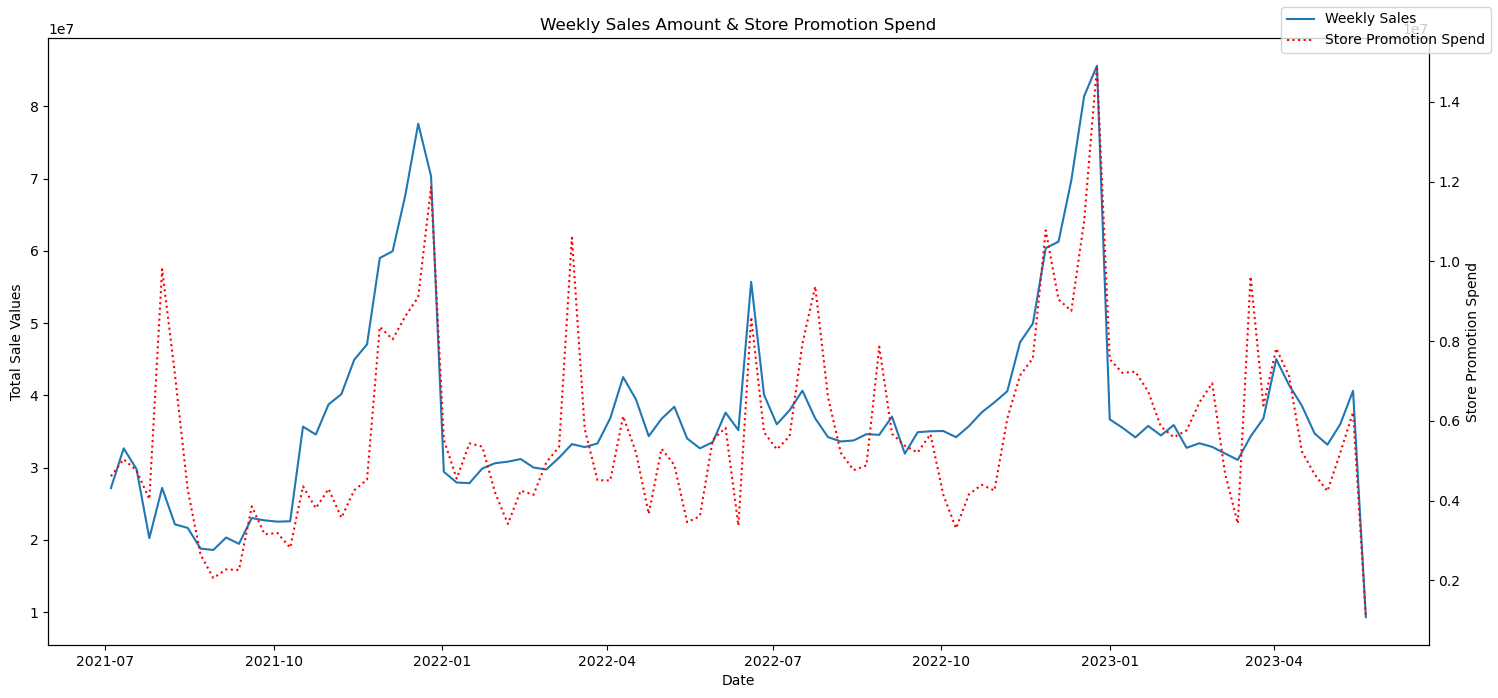

In [86]:
fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(111)
ax.plot(time_sales['financial_week_end_date'], time_sales['total_sale_value'], label='Weekly Sales')

ax2 = ax.twinx()
ax2.plot(promotion['financial_week_end_date'], promotion['total_promotional_sales_value'], color='red'
         , linestyle=':',label = 'Store Promotion Spend')


ax.set_ylabel('Total Sale Values')
ax.set_xlabel('Date')
ax2.set_ylabel('Store Promotion Spend')
fig.legend(loc="upper right")
plt.title('Weekly Sales Amount & Store Promotion Spend')

plt.tight_layout()
plt.savefig('line2.png',dpi =100)
plt.show()

In [87]:
#promotion depends on the sales values 

In [88]:
# strategy on promotion timing (festivals) should be focused since some investment on promotion did not add value 
# to the sales value
# the trend shows there are postive correlations between promotion fees and sales growth 

In [89]:
df_train_test_cleaned['price_lifestage_segment'].value_counts()

Budget-Young Families                195153
Mainstream-Older Singles/Couples     166243
Mainstream-Young Families            160767
Budget-Older Singles/Couples         138146
Mainstream-Retirees                  133369
Mainstream-Young Singles/Couples     117011
Premium-Older Singles/Couples        115552
Budget-Retirees                      110828
Premium-Young Families               104866
Budget-Older Families                103010
Budget-New Families                  101359
Budget-Young Singles/Couples         100759
Premium-Retirees                      92081
Mainstream-New Families               91410
Mainstream-Older Families             91070
Mainstream-Midage Singles/Couples     79758
Budget-Midage Singles/Couples         66062
Premium-Young Singles/Couples         62842
Premium-Midage Singles/Couples        60013
Premium-New Families                  58197
Premium-Older Families                44614
Name: price_lifestage_segment, dtype: int64

In [90]:
price_life_stage_median = df_train_test_cleaned.groupby('price_lifestage_segment')['total_sale_value'].median().reset_index()

In [91]:
price_life_stage_median = price_life_stage_median.sort_values(by = 'total_sale_value', ascending=False)

In [92]:
price_life_stage_median

,price_lifestage_segment,total_sale_value
5,Budget-Young Families,1236.050
1,Budget-New Families,1135.850
12,Mainstream-Young Families,1110.720
2,Budget-Older Families,943.625
8,Mainstream-New Families,927.410
19,Premium-Young Families,924.455
10,Mainstream-Older Singles/Couples,921.300
3,Budget-Older Singles/Couples,894.695
9,Mainstream-Older Families,840.345
6,Budget-Young Singles/Couples,797.630


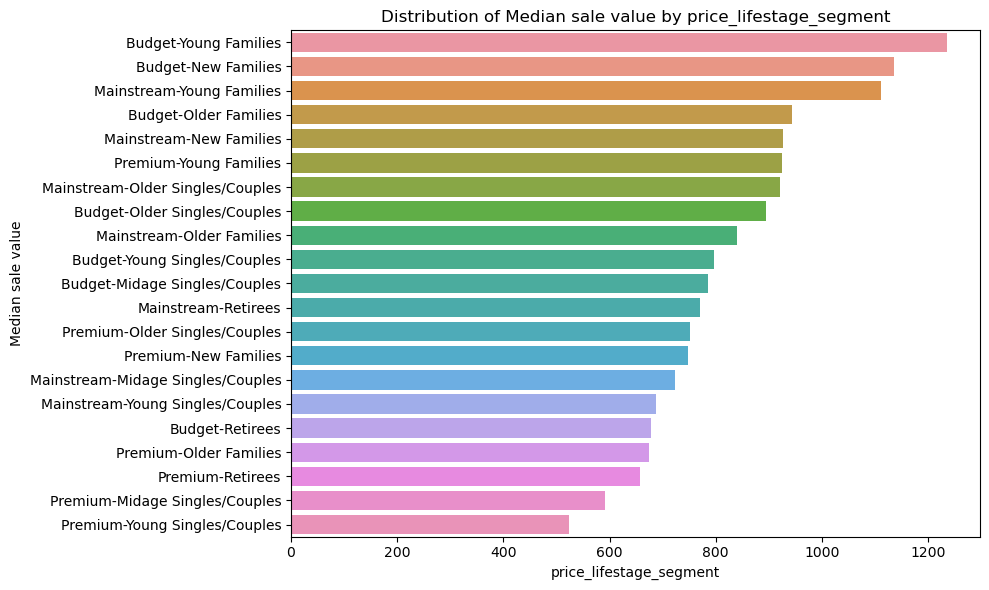

In [93]:
# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size

# Use seaborn to create a bar plot with the sorted order
sns.barplot(data=price_life_stage_median, x='total_sale_value', y='price_lifestage_segment')

# Add labels and title
plt.xlabel('price_lifestage_segment')
plt.ylabel('Median sale value')
plt.title('Distribution of Median sale value by price_lifestage_segment')
plt.tight_layout()

# Save the figure
plt.savefig("distribution of median sale value by pricelifestagesegment.png")

# Show the plot
plt.show()

In [94]:
# can be divided by familiies and non-families

In [95]:
# separate the family and non-family

In [96]:
df_train_test_cleaned['family_or_not'] = df_train_test_cleaned['price_lifestage_segment'].str.contains('Families', case=False, regex=True)

df_train_test_cleaned['family_or_not'] = df_train_test_cleaned['family_or_not'].map({True: 'family', False: 'non-family'})

print(df_train_test_cleaned['family_or_not'])

0              family
1          non-family
2          non-family
3              family
4              family
              ...    
2193105    non-family
2193106        family
2193107        family
2193108    non-family
2193109    non-family
Name: family_or_not, Length: 2193110, dtype: object


In [97]:
df_train_test_cleaned['family_or_not'].value_counts()

non-family    1242664
family         950446
Name: family_or_not, dtype: int64

In [100]:
# separate the budget, mainstream and premium

In [101]:
df_train_test_cleaned['economy_status'] = ''

# Set 'economy_status' values based on keyword presence
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('Budget', case=False, regex=True), 'economy_status'] = 'Budget'
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('Mainstream', case=False, regex=True), 'economy_status'] = 'Mainstream'
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('Premium', case=False, regex=True), 'economy_status'] = 'Premium'

# Display the DataFrame
print(df_train_test_cleaned['economy_status'])

0              Budget
1              Budget
2          Mainstream
3          Mainstream
4             Premium
              ...    
2193105    Mainstream
2193106       Premium
2193107    Mainstream
2193108        Budget
2193109       Premium
Name: economy_status, Length: 2193110, dtype: object


In [102]:
df_train_test_cleaned['economy_status'].value_counts()

Mainstream    839628
Budget        815317
Premium       538165
Name: economy_status, dtype: int64

In [106]:
df_train_test_cleaned['age_group'] = ''

# Set 'economy_status' values based on keyword presence
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('New', case=False, regex=True), 'age_group'] = 'New'
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('Young', case=False, regex=True), 'age_group'] = 'Young'
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('Midage', case=False, regex=True), 'age_group'] = 'Midage'
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('Retirees', case=False, regex=True), 'age_group'] = 'Retirees'
df_train_test_cleaned.loc[df_train_test_cleaned['price_lifestage_segment'].str.contains('Older', case=False, regex=True), 'age_group'] = 'Older'
# Display the DataFrame
print(df_train_test_cleaned['age_group'])

0               New
1          Retirees
2             Young
3             Young
4               New
             ...   
2193105    Retirees
2193106         New
2193107         New
2193108       Young
2193109      Midage
Name: age_group, Length: 2193110, dtype: object


In [107]:
df_train_test_cleaned['age_group'].value_counts()

Young       741398
Older       658635
Retirees    336278
New         250966
Midage      205833
Name: age_group, dtype: int64

In [108]:
age_group_mapping = {
    'Young': 'Young_Or_Mid',
    'New': 'Young_Or_Mid',
    'Midage': 'Young_Or_Mid',
    'Older': 'Old',
    'Retirees': 'Old'
}

# Add a new column 'consolidated_age_group' based on the mapping
df_train_test_cleaned['consolidated_age_group'] = df_train_test_cleaned['age_group'].map(age_group_mapping)

In [109]:
df_train_test_cleaned['consolidated_age_group'].value_counts()

Young_Or_Mid    1198197
Old              994913
Name: consolidated_age_group, dtype: int64

In [110]:
drop_column = ['price_lifestage_segment', 'age_group', 'total_promotional_sales_value','total_sale_value']

df_train_test_cleaned.drop(columns=drop_column, inplace=True)

In [111]:
df_train_test_cleaned

,store_id,sales_channel,customer_state,customer_postcode,customer_count,transaction_count,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income,log_total_sale,log_promotional_total_sale,family_or_not,economy_status,consolidated_age_group
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,51,77,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,0.0,813,8.808562,7.343931,family,Budget,Young_Or_Mid
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,8,8,2022-01-02,VIC,3220,-38.1467,144.3587,False,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803,5.898609,4.507778,non-family,Budget,Old
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,10,11,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,0.0,787,6.100879,2.374906,non-family,Mainstream,Young_Or_Mid
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,79,119,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734,8.919973,7.220008,family,Mainstream,Young_Or_Mid
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,58,84,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803,8.727850,6.233606,family,Premium,Young_Or_Mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,166,226,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813,9.630849,7.390583,non-family,Mainstream,Old
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,13,16,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,0.0,848,7.099086,4.978456,family,Premium,Young_Or_Mid
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,44,57,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203",8.016684,5.933968,family,Mainstream,Young_Or_Mid
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,142,221,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803,9.070002,7.610546,non-family,Budget,Young_Or_Mid


In [112]:
df_train_test_cleaned

,store_id,sales_channel,customer_state,customer_postcode,customer_count,transaction_count,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income,log_total_sale,log_promotional_total_sale,family_or_not,economy_status,consolidated_age_group
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,51,77,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,0.0,813,8.808562,7.343931,family,Budget,Young_Or_Mid
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,8,8,2022-01-02,VIC,3220,-38.1467,144.3587,False,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803,5.898609,4.507778,non-family,Budget,Old
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,10,11,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,0.0,787,6.100879,2.374906,non-family,Mainstream,Young_Or_Mid
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,79,119,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734,8.919973,7.220008,family,Mainstream,Young_Or_Mid
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,58,84,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803,8.727850,6.233606,family,Premium,Young_Or_Mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,166,226,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813,9.630849,7.390583,non-family,Mainstream,Old
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,13,16,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,0.0,848,7.099086,4.978456,family,Premium,Young_Or_Mid
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,44,57,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203",8.016684,5.933968,family,Mainstream,Young_Or_Mid
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,142,221,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803,9.070002,7.610546,non-family,Budget,Young_Or_Mid


In [113]:
df_train_test_cleaned['sales_channel'] = df_train_test_cleaned['sales_channel'].replace(['Digital - ClickCollect', 'Digital - Delivery'], 'Digital')

In [211]:
import folium
import pandas as pd
from folium.plugins import HeatMap

In [ ]:
m = folium.Map([-25.2744, 133.7751], zoom_start=5)

# Step 4: Create a list of latitude, longitude, and total_sale_value for each store
store_info = df_train_test_cleaned[['store_latitude', 'store_longitude', 'store_total_sale_value']].values.tolist()

# Step 5: Create a HeatMap layer using the store information
HeatMap(store_info, radius=15, gradient={0.2: 'blue', 0.4: 'purple', 0.6: 'orange', 1: 'red'}).add_to(m)

# Step 6: Optionally, add markers for individual stores to the map
for index, row in df_train_test_cleaned.iterrows():
    folium.Marker([row['store_latitude'], row['store_longitude']],
                  popup=f"Store ID: {row['store_id']}, Total Sales: {row['store_total_sale_value']}").add_to(m)

# Step 7: Save the map to an HTML file
m.save("store_sales_heatmap.html") 

In [122]:
df = df_train_test_cleaned

# Core feature engineering

In [123]:
from category_encoders.target_encoder import TargetEncoder
#Wuchengrui part
# df = pd.get_dummies(df, columns = ['sales_channel'], drop_first = True)
encoder = TargetEncoder().fit(df['customer_state'], df['log_total_sale']) 
df['customer_state_encoding']= encoder.transform(df['customer_state'])
#Chaimingchen part

#week_end
first_day = df['financial_week_end_date'].min()
df['week_count'] = (df['financial_week_end_date'] - first_day).dt.days // 7
#family
df['family_or_not'] = df['family_or_not'].replace({'non-family': 0, 'family': 1})
#economy_status
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['economy_status'] = label_encoder.fit_transform(df['economy_status'])

In [124]:
df['store_total_sale_value'].describe()

count    2.193110e+06
mean     5.283339e+07
std      1.335322e+07
min      4.225774e+05
25%      4.561220e+07
50%      5.222089e+07
75%      6.226790e+07
max      8.571700e+07
Name: store_total_sale_value, dtype: float64

In [125]:
stats.skew(df['store_total_sale_value'])# good 

-0.7229179273878575

In [126]:
df['media_amount_spend'].describe()

count    2.193110e+06
mean     5.533706e+05
std      1.115797e+06
min      0.000000e+00
25%      5.918100e+04
50%      1.619080e+05
75%      3.830990e+05
max      7.683541e+06
Name: media_amount_spend, dtype: float64

In [127]:
stats.skew(df['media_amount_spend'])# too big

3.485367677942089

In [128]:
from scipy import stats

BoxCox_media_amount_spend, lambda_value = stats.boxcox(df['media_amount_spend'] + 1)
df['BoxCox_media_amount_spend'] = BoxCox_media_amount_spend

In [129]:
stats.skew(df['BoxCox_media_amount_spend'])

-0.14493717247638965

In [131]:
#categorical: consolidated_age_group(done), store_state(done), co_location_flag(done), distance_to_kmart(done), distance_to_target(done)

# Feature engineering:

In [132]:
df['consolidated_age_group'].value_counts()

Young_Or_Mid    1198197
Old              994913
Name: consolidated_age_group, dtype: int64

In [133]:
df['store_state'].value_counts()

NSW    652894
QLD    567248
VIC    353379
WA     242197
SA     223350
ACT     77287
TAS     50220
NT      26535
Name: store_state, dtype: int64

In [134]:
df['co_location_flag'].value_counts()

True     2022701
False     170409
Name: co_location_flag, dtype: int64

In [135]:
df['distance_to_kmart'].value_counts()

Same Centre    946268
>5 KM          574313
3-5 KM         392697
1-3 KM         146819
<1 KM          133013
Name: distance_to_kmart, dtype: int64

In [136]:
df['distance_to_target'].value_counts()

>5 KM          979508
Same Centre    646318
3-5 KM         313785
1-3 KM         127251
<1 KM          126248
Name: distance_to_target, dtype: int64

In [137]:
# Dummy variables creation for consolidated_age_group, co_location_flag, because it only has 2 categories 

In [138]:
dummies_age_group = pd.get_dummies(df['consolidated_age_group'],prefix='age',drop_first=True)
dummies_age_group.head()

,age_Young_Or_Mid
0,1
1,0
2,1
3,1
4,1


In [139]:
df = pd.concat([df, dummies_age_group], axis=1)

In [140]:
dummies_co_location = df['co_location_flag'].astype(int).to_frame()
dummies_co_location.head()

,co_location_flag
0,1
1,0
2,1
3,1
4,1


In [141]:
df = pd.concat([df, dummies_co_location], axis=1)

In [142]:
# to differentiate the the store state and the customer state regarding to the response variable, target encoding
# will be suitable for realizing the variables objectives 

In [143]:
encoder_store_state = TargetEncoder().fit(df['store_state'],df['log_total_sale'])# change to store sales 
df['store_state_encoding'] = encoder_store_state.transform(df['store_state'])
#because the response is approximately normal distribution, using mean is appropriate

In [144]:
df['store_state_encoding'].to_frame().head()

,store_state_encoding
0,6.974716
1,6.744790
2,6.901210
3,6.720817
4,6.744790


In [145]:
# 'distance to kmart and target' variable: because these 2 variables are all unequally portioned, making the after
# ML model give much more importance to the category which has overwhelmingly more observations. Necessary to combine
# some of the categories to make them approximately equal observed.

In [146]:
df['distance_category_kmart'] = df['distance_to_kmart'].replace({
    'Same Centre': 'Very Close',
    '>5 KM': 'Distant',
    '3-5 KM': 'Close',
    '1-3 KM': 'Close',
    '<1 KM': 'Close'
})
# change to ordinal 

df['distance_category_target'] = df['distance_to_target'].replace({
    'Same Centre': 'Very Close',
    '>5 KM': 'Distant',
    '3-5 KM': 'Close',
    '1-3 KM': 'Close',
    '<1 KM': 'Close'
})

In [147]:
label_encoder = LabelEncoder()
df['kmart_distance'] = label_encoder.fit_transform(df['distance_category_kmart'])
df['kmart_distance']

0          1
1          0
2          2
3          1
4          2
          ..
2193105    1
2193106    2
2193107    2
2193108    2
2193109    1
Name: kmart_distance, Length: 2193110, dtype: int64

In [148]:
df['target_distance'] = label_encoder.fit_transform(df['distance_category_target'])
df['target_distance']

0          1
1          2
2          2
3          1
4          1
          ..
2193105    1
2193106    2
2193107    1
2193108    1
2193109    1
Name: target_distance, Length: 2193110, dtype: int64

In [149]:
df

,store_id,sales_channel,customer_state,customer_postcode,customer_count,transaction_count,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,store_total_sale_value_ex_gst,store_total_promotional_sales_value,media_amount_spend,state_median_income,log_total_sale,log_promotional_total_sale,family_or_not,economy_status,consolidated_age_group,customer_state_encoding,week_count,BoxCox_media_amount_spend,age_Young_Or_Mid,co_location_flag,store_state_encoding,distance_category_kmart,distance_category_target,kmart_distance,target_distance
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.0,51,77,2023-03-26,NSW,2550,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,33178770.28,5860172.93,0.0,813,8.808562,7.343931,1,0,Young_Or_Mid,6.967140,90,0.000000,1,1,6.974716,Distant,Distant,1,1
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.0,8,8,2022-01-02,VIC,3220,-38.1467,144.3587,False,1-3 KM,Same Centre,47365307.38,43201624.67,7067878.78,720625.0,803,5.898609,4.507778,0,0,Old,6.745430,26,68.786286,0,0,6.744790,Close,Very Close,0,2
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.0,10,11,2023-03-19,QLD,4122,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,62536076.31,9377664.86,0.0,787,6.100879,2.374906,0,1,Young_Or_Mid,6.900555,89,0.000000,1,1,6.901210,Very Close,Very Close,2,2
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.0,79,119,2023-01-29,SA,5253,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,37285616.84,6113728.48,34692.0,734,8.919973,7.220008,1,1,Young_Or_Mid,6.720996,82,35.297047,1,1,6.720817,Distant,Distant,1,1
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,58,84,2021-11-07,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,5625606.0,803,8.727850,6.233606,1,2,Young_Or_Mid,6.745430,18,106.149990,1,1,6.744790,Very Close,Distant,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,fc2751520dda99c0c7f267904fb483e7,Store,NSW,2594.0,166,226,2021-12-19,NSW,2594,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,37243969.29,5438976.29,438352.0,813,9.630849,7.390583,0,1,Old,6.967140,24,61.823811,0,0,6.974716,Distant,Distant,1,1
2193106,06dc9c10cb8eb46b5fcca86460df8662,Store,WA,6055.0,13,16,2023-04-02,WA,6056,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,63498115.67,9680061.90,0.0,848,7.099086,4.978456,1,2,Young_Or_Mid,6.848400,91,0.000000,1,1,6.848401,Very Close,Very Close,2,2
2193107,c22b7285b63e1d6f09a10dc258858d48,Store,ACT,2913.0,44,57,2022-03-06,ACT,2912,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,48955061.29,7322644.83,7403.0,"1,203",8.016684,5.933968,1,1,Young_Or_Mid,6.583269,35,24.614048,1,1,6.575553,Very Close,Distant,2,1
2193108,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.0,142,221,2023-03-05,VIC,3064,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,44473926.98,7027259.92,60130.0,803,9.070002,7.610546,0,0,Young_Or_Mid,6.745430,87,39.968144,1,1,6.744790,Very Close,Distant,2,1


In [150]:
df.drop('customer_postcode', axis=1, inplace=True)
df.drop('store_postcode', axis=1, inplace=True)

In [151]:
df = df.drop(['store_id', 'store_total_promotional_sales_value', 'store_total_sale_value_ex_gst'],axis =1)

In [152]:
df

,sales_channel,customer_state,customer_count,transaction_count,financial_week_end_date,store_state,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,store_total_sale_value,media_amount_spend,state_median_income,log_total_sale,log_promotional_total_sale,family_or_not,economy_status,consolidated_age_group,customer_state_encoding,week_count,BoxCox_media_amount_spend,age_Young_Or_Mid,co_location_flag,store_state_encoding,distance_category_kmart,distance_category_target,kmart_distance,target_distance
0,Store,NSW,51,77,2023-03-26,NSW,-36.6785,149.8398,True,>5 KM,>5 KM,36395242.58,0.0,813,8.808562,7.343931,1,0,Young_Or_Mid,6.967140,90,0.000000,1,1,6.974716,Distant,Distant,1,1
1,Store,VIC,8,8,2022-01-02,VIC,-38.1467,144.3587,False,1-3 KM,Same Centre,47365307.38,720625.0,803,5.898609,4.507778,0,0,Old,6.745430,26,68.786286,0,0,6.744790,Close,Very Close,0,2
2,Store,QLD,10,11,2023-03-19,QLD,-27.5600,153.0811,True,Same Centre,Same Centre,68508871.62,0.0,787,6.100879,2.374906,0,1,Young_Or_Mid,6.900555,89,0.000000,1,1,6.901210,Very Close,Very Close,2,2
3,Store,SA,79,119,2023-01-29,SA,-35.1183,139.2747,True,>5 KM,>5 KM,40837425.16,34692.0,734,8.919973,7.220008,1,1,Young_Or_Mid,6.720996,82,35.297047,1,1,6.720817,Distant,Distant,1,1
4,Store,VIC,58,84,2021-11-07,VIC,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,5625606.0,803,8.727850,6.233606,1,2,Young_Or_Mid,6.745430,18,106.149990,1,1,6.744790,Very Close,Distant,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,Store,NSW,166,226,2021-12-19,NSW,-34.3036,148.2702,False,>5 KM,>5 KM,40774790.56,438352.0,813,9.630849,7.390583,0,1,Old,6.967140,24,61.823811,0,0,6.974716,Distant,Distant,1,1
2193106,Store,WA,13,16,2023-04-02,WA,-31.8903,116.0015,True,Same Centre,Same Centre,69622766.17,0.0,848,7.099086,4.978456,1,2,Young_Or_Mid,6.848400,91,0.000000,1,1,6.848401,Very Close,Very Close,2,2
2193107,Store,ACT,44,57,2022-03-06,ACT,-35.1857,149.1361,True,Same Centre,>5 KM,53644551.42,7403.0,"1,203",8.016684,5.933968,1,1,Young_Or_Mid,6.583269,35,24.614048,1,1,6.575553,Very Close,Distant,2,1
2193108,Store,VIC,142,221,2023-03-05,VIC,-37.5939,144.9103,True,Same Centre,>5 KM,48763639.75,60130.0,803,9.070002,7.610546,0,0,Young_Or_Mid,6.745430,87,39.968144,1,1,6.744790,Very Close,Distant,2,1


In [153]:
df = df.drop(['sales_channel','customer_state','store_state','distance_category_target', 'distance_category_kmart', 'media_amount_spend','distance_to_target','distance_to_kmart','co_location_flag','consolidated_age_group', 'financial_week_end_date'], axis=1)

In [154]:
df

,customer_count,transaction_count,store_latitude,store_longitude,store_total_sale_value,state_median_income,log_total_sale,log_promotional_total_sale,family_or_not,economy_status,customer_state_encoding,week_count,BoxCox_media_amount_spend,age_Young_Or_Mid,store_state_encoding,kmart_distance,target_distance
0,51,77,-36.6785,149.8398,36395242.58,813,8.808562,7.343931,1,0,6.967140,90,0.000000,1,6.974716,1,1
1,8,8,-38.1467,144.3587,47365307.38,803,5.898609,4.507778,0,0,6.745430,26,68.786286,0,6.744790,0,2
2,10,11,-27.5600,153.0811,68508871.62,787,6.100879,2.374906,0,1,6.900555,89,0.000000,1,6.901210,2,2
3,79,119,-35.1183,139.2747,40837425.16,734,8.919973,7.220008,1,1,6.720996,82,35.297047,1,6.720817,1,1
4,58,84,-37.5939,144.9103,48763639.75,803,8.727850,6.233606,1,2,6.745430,18,106.149990,1,6.744790,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,166,226,-34.3036,148.2702,40774790.56,813,9.630849,7.390583,0,1,6.967140,24,61.823811,0,6.974716,1,1
2193106,13,16,-31.8903,116.0015,69622766.17,848,7.099086,4.978456,1,2,6.848400,91,0.000000,1,6.848401,2,2
2193107,44,57,-35.1857,149.1361,53644551.42,"1,203",8.016684,5.933968,1,1,6.583269,35,24.614048,1,6.575553,2,1
2193108,142,221,-37.5939,144.9103,48763639.75,803,9.070002,7.610546,0,0,6.745430,87,39.968144,1,6.744790,2,1


In [155]:
df_for_modelling = df.drop(['customer_count','transaction_count','log_promotional_total_sale'],axis=1)

In [156]:
df_for_modelling['state_median_income'] = df_for_modelling['state_median_income'].str.replace(',', '').astype(float)

In [157]:
df_for_modelling['state_median_income'].value_counts()

813.0     652894
787.0     567248
803.0     353379
848.0     242197
734.0     223350
1203.0     77287
701.0      50220
936.0      26535
Name: state_median_income, dtype: int64

In [158]:

df_train_modelling = df_for_modelling.iloc[:1827592]
df_test_modelling = df_for_modelling.iloc[1827592:].reset_index(drop = True)

x_train_modelling = df_train_modelling.drop(['log_total_sale'], axis=1).copy()
y_train_modelling = df_train_modelling[['log_total_sale']].copy()
x_test_modelling = df_test_modelling.drop(['log_total_sale'], axis=1).copy()
y_test_modelling = df_test_modelling[['log_total_sale']].copy()

In [159]:
df_for_modelling

,store_latitude,store_longitude,store_total_sale_value,state_median_income,log_total_sale,family_or_not,economy_status,customer_state_encoding,week_count,BoxCox_media_amount_spend,age_Young_Or_Mid,store_state_encoding,kmart_distance,target_distance
0,-36.6785,149.8398,36395242.58,813.0,8.808562,1,0,6.967140,90,0.000000,1,6.974716,1,1
1,-38.1467,144.3587,47365307.38,803.0,5.898609,0,0,6.745430,26,68.786286,0,6.744790,0,2
2,-27.5600,153.0811,68508871.62,787.0,6.100879,0,1,6.900555,89,0.000000,1,6.901210,2,2
3,-35.1183,139.2747,40837425.16,734.0,8.919973,1,1,6.720996,82,35.297047,1,6.720817,1,1
4,-37.5939,144.9103,48763639.75,803.0,8.727850,1,2,6.745430,18,106.149990,1,6.744790,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193105,-34.3036,148.2702,40774790.56,813.0,9.630849,0,1,6.967140,24,61.823811,0,6.974716,1,1
2193106,-31.8903,116.0015,69622766.17,848.0,7.099086,1,2,6.848400,91,0.000000,1,6.848401,2,2
2193107,-35.1857,149.1361,53644551.42,1203.0,8.016684,1,1,6.583269,35,24.614048,1,6.575553,2,1
2193108,-37.5939,144.9103,48763639.75,803.0,9.070002,0,0,6.745430,87,39.968144,1,6.744790,2,1


In [160]:
x_test_modelling

,store_latitude,store_longitude,store_total_sale_value,state_median_income,family_or_not,economy_status,customer_state_encoding,week_count,BoxCox_media_amount_spend,age_Young_Or_Mid,store_state_encoding,kmart_distance,target_distance
0,-35.0138,138.5447,65108066.68,734.0,0,1,6.720996,56,33.609557,0,6.720817,2,2
1,-34.9676,138.5901,69411581.96,734.0,0,1,6.720996,39,60.552980,0,6.720817,0,0
2,-35.1384,138.4918,49629019.10,734.0,1,1,6.720996,79,40.012644,0,6.720817,2,0
3,-37.7691,144.8865,52041127.47,803.0,0,1,6.745430,18,106.149990,0,6.744790,2,1
4,-27.2476,153.0174,72567324.32,787.0,1,2,6.900555,69,51.181209,1,6.901210,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365513,-34.3036,148.2702,40774790.56,813.0,0,1,6.967140,24,61.823811,0,6.974716,1,1
365514,-31.8903,116.0015,69622766.17,848.0,1,2,6.848400,91,0.000000,1,6.848401,2,2
365515,-35.1857,149.1361,53644551.42,1203.0,1,1,6.583269,35,24.614048,1,6.575553,2,1
365516,-37.5939,144.9103,48763639.75,803.0,0,0,6.745430,87,39.968144,1,6.744790,2,1


In [161]:
y_test_modelling

,log_total_sale
0,6.396296
1,7.457615
2,6.796600
3,7.896449
4,6.274348
...,...
365513,9.630849
365514,7.099086
365515,8.016684
365516,9.070002


In [162]:
x_train = x_train_modelling
y_train = y_train_modelling

x_test = x_test_modelling
y_test = y_test_modelling

In [163]:
x_train

,store_latitude,store_longitude,store_total_sale_value,state_median_income,family_or_not,economy_status,customer_state_encoding,week_count,BoxCox_media_amount_spend,age_Young_Or_Mid,store_state_encoding,kmart_distance,target_distance
0,-36.6785,149.8398,36395242.58,813.0,1,0,6.967140,90,0.000000,1,6.974716,1,1
1,-38.1467,144.3587,47365307.38,803.0,0,0,6.745430,26,68.786286,0,6.744790,0,2
2,-27.5600,153.0811,68508871.62,787.0,0,1,6.900555,89,0.000000,1,6.901210,2,2
3,-35.1183,139.2747,40837425.16,734.0,1,1,6.720996,82,35.297047,1,6.720817,1,1
4,-37.5939,144.9103,48763639.75,803.0,1,2,6.745430,18,106.149990,1,6.744790,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827587,-28.0805,153.3836,66777963.54,787.0,0,1,6.900555,2,43.017379,1,6.901210,2,2
1827588,-31.8720,115.8592,49658168.95,848.0,0,1,6.848400,76,45.998529,0,6.848401,2,0
1827589,-32.2476,115.8123,50115511.18,848.0,0,1,6.848400,32,42.425849,1,6.848401,1,1
1827590,-33.6917,150.9247,76739627.92,813.0,0,1,6.967140,76,59.831775,0,6.974716,2,1


# modelling 

# Neural Network

Epoch 1/50
22845/22845 [==============================] - 29s 1ms/step - loss: 0.8536 - root_mean_squared_error: 0.9239 - val_loss: 0.8168 - val_root_mean_squared_error: 0.9038
Epoch 2/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.8234 - root_mean_squared_error: 0.9074 - val_loss: 0.8081 - val_root_mean_squared_error: 0.8989
Epoch 3/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.8157 - root_mean_squared_error: 0.9032 - val_loss: 0.8000 - val_root_mean_squared_error: 0.8944
Epoch 4/50
22845/22845 [==============================] - 31s 1ms/step - loss: 0.8104 - root_mean_squared_error: 0.9002 - val_loss: 0.7947 - val_root_mean_squared_error: 0.8915
Epoch 5/50
22845/22845 [==============================] - 34s 1ms/step - loss: 0.8071 - root_mean_squared_error: 0.8984 - val_loss: 0.7912 - val_root_mean_squared_error: 0.8895
Epoch 6/50
22845/22845 [==============================] - 33s 1ms/step - loss: 0.8044 - root_mean_squared_error: 0.

22845/22845 [==============================] - 35s 2ms/step - loss: 0.8016 - root_mean_squared_error: 0.8953 - val_loss: 0.7938 - val_root_mean_squared_error: 0.8910
Epoch 8/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.7998 - root_mean_squared_error: 0.8943 - val_loss: 0.7894 - val_root_mean_squared_error: 0.8885
Epoch 9/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.7988 - root_mean_squared_error: 0.8938 - val_loss: 0.7878 - val_root_mean_squared_error: 0.8876
Epoch 10/50
22845/22845 [==============================] - 34s 1ms/step - loss: 0.7978 - root_mean_squared_error: 0.8932 - val_loss: 0.7884 - val_root_mean_squared_error: 0.8879
Epoch 11/50
22845/22845 [==============================] - 33s 1ms/step - loss: 0.7971 - root_mean_squared_error: 0.8928 - val_loss: 0.7854 - val_root_mean_squared_error: 0.8862
Epoch 12/50
22845/22845 [==============================] - 32s 1ms/step - loss: 0.7964 - root_mean_squared_error: 0.8924 - v

22845/22845 [==============================] - 27s 1ms/step - loss: 0.7949 - root_mean_squared_error: 0.8916 - val_loss: 0.7879 - val_root_mean_squared_error: 0.8876
Epoch 13/50
22845/22845 [==============================] - 27s 1ms/step - loss: 0.7946 - root_mean_squared_error: 0.8914 - val_loss: 0.7869 - val_root_mean_squared_error: 0.8871
Epoch 14/50
22845/22845 [==============================] - 27s 1ms/step - loss: 0.7936 - root_mean_squared_error: 0.8908 - val_loss: 0.7885 - val_root_mean_squared_error: 0.8880
Epoch 15/50
22845/22845 [==============================] - 27s 1ms/step - loss: 0.7931 - root_mean_squared_error: 0.8906 - val_loss: 0.7875 - val_root_mean_squared_error: 0.8874
Epoch 16/50
22845/22845 [==============================] - 27s 1ms/step - loss: 0.7925 - root_mean_squared_error: 0.8902 - val_loss: 0.7863 - val_root_mean_squared_error: 0.8867
Epoch 17/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.7920 - root_mean_squared_error: 0.8899 -

22845/22845 [==============================] - 30s 1ms/step - loss: 0.7875 - root_mean_squared_error: 0.8874 - val_loss: 0.7766 - val_root_mean_squared_error: 0.8812
Epoch 34/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.7874 - root_mean_squared_error: 0.8873 - val_loss: 0.7759 - val_root_mean_squared_error: 0.8809
Epoch 35/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.7867 - root_mean_squared_error: 0.8870 - val_loss: 0.7734 - val_root_mean_squared_error: 0.8794
Epoch 36/50
22845/22845 [==============================] - 40s 2ms/step - loss: 0.7868 - root_mean_squared_error: 0.8870 - val_loss: 0.7747 - val_root_mean_squared_error: 0.8801
Epoch 37/50
22845/22845 [==============================] - 36s 2ms/step - loss: 0.7864 - root_mean_squared_error: 0.8868 - val_loss: 0.7823 - val_root_mean_squared_error: 0.8845
Epoch 38/50
22845/22845 [==============================] - 27s 1ms/step - loss: 0.7861 - root_mean_squared_error: 0.8866 -

Epoch 6/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.9200 - root_mean_squared_error: 0.9591 - val_loss: 0.8453 - val_root_mean_squared_error: 0.9194
Epoch 7/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.9250 - root_mean_squared_error: 0.9618 - val_loss: 0.8852 - val_root_mean_squared_error: 0.9408
Epoch 8/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.9199 - root_mean_squared_error: 0.9591 - val_loss: 0.8509 - val_root_mean_squared_error: 0.9225
Epoch 9/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.9399 - root_mean_squared_error: 0.9695 - val_loss: 0.8582 - val_root_mean_squared_error: 0.9264
Epoch 10/50
22845/22845 [==============================] - 30s 1ms/step - loss: 0.9213 - root_mean_squared_error: 0.9599 - val_loss: 0.8441 - val_root_mean_squared_error: 0.9187
Epoch 11/50
22845/22845 [==============================] - 32s 1ms/step - loss: 0.9104 - root_mean_squared_error: 

22845/22845 [==============================] - 28s 1ms/step - loss: 0.9361 - root_mean_squared_error: 0.9675 - val_loss: 0.8844 - val_root_mean_squared_error: 0.9404
Epoch 8/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.9129 - root_mean_squared_error: 0.9554 - val_loss: 0.8497 - val_root_mean_squared_error: 0.9218
Epoch 9/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.9224 - root_mean_squared_error: 0.9604 - val_loss: 0.8666 - val_root_mean_squared_error: 0.9309
Epoch 10/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.8969 - root_mean_squared_error: 0.9471 - val_loss: 0.8599 - val_root_mean_squared_error: 0.9273
Epoch 11/50
22845/22845 [==============================] - 28s 1ms/step - loss: 0.9011 - root_mean_squared_error: 0.9492 - val_loss: 0.8428 - val_root_mean_squared_error: 0.9181
Epoch 12/50
22845/22845 [==============================] - 29s 1ms/step - loss: 0.9026 - root_mean_squared_error: 0.9500 - v

Epoch 5/50
22845/22845 [==============================] - 34s 1ms/step - loss: 1.0199 - root_mean_squared_error: 1.0099 - val_loss: 0.8706 - val_root_mean_squared_error: 0.9330
Epoch 6/50
22845/22845 [==============================] - 32s 1ms/step - loss: 0.9890 - root_mean_squared_error: 0.9945 - val_loss: 0.8778 - val_root_mean_squared_error: 0.9369
Epoch 7/50
22845/22845 [==============================] - 33s 1ms/step - loss: 0.9433 - root_mean_squared_error: 0.9712 - val_loss: 0.8805 - val_root_mean_squared_error: 0.9383
Epoch 8/50
22845/22845 [==============================] - 32s 1ms/step - loss: 0.9522 - root_mean_squared_error: 0.9758 - val_loss: 0.8773 - val_root_mean_squared_error: 0.9367
Epoch 9/50
22845/22845 [==============================] - 32s 1ms/step - loss: 0.9833 - root_mean_squared_error: 0.9916 - val_loss: 0.9170 - val_root_mean_squared_error: 0.9576
Epoch 10/50
22845/22845 [==============================] - 32s 1ms/step - loss: 1.4261 - root_mean_squared_error: 1

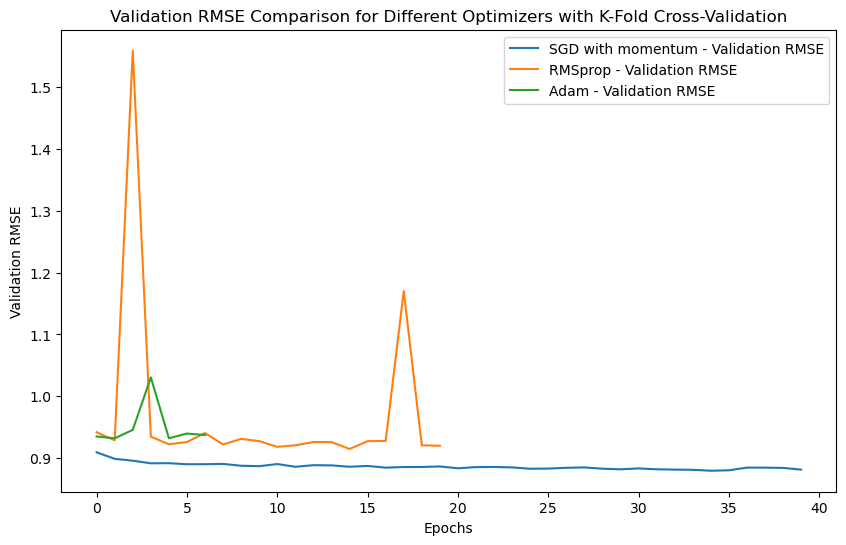

In [164]:
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



def scale_datasets(x_train, x_test):
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(standard_scaler.fit_transform(x_train), columns=x_train.columns)
    x_test_scaled = pd.DataFrame(standard_scaler.transform(x_test), columns=x_test.columns)
    return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

hidden_units1 = 256
hidden_units2 = 128
hidden_units3 = 64
learning_rate = 0.01

def build_model_using_sequential():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal'),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(hidden_units2, kernel_initializer='normal'),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(hidden_units3, kernel_initializer='normal'),
        LeakyReLU(alpha=0.01),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    return model

optimizers = [
    
    (legacy.SGD(learning_rate=learning_rate, momentum=0.9), 'SGD with momentum'),
    (legacy.RMSprop(learning_rate=learning_rate), 'RMSprop'),
    (legacy.Adam(learning_rate=learning_rate), 'Adam')
]


num_folds = 5  

all_val_rmse_values = []


kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

plt.figure(figsize=(10, 6))


epochs = 50

for i, (optimizer, optimizer_name) in enumerate(optimizers):

    optimizer_val_rmse_values = []

    for train_index, val_index in kf.split(x_train_scaled):

        x_train_fold, x_val_fold = x_train_scaled.iloc[train_index], x_train_scaled.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]


        model = build_model_using_sequential()
        rmse = RootMeanSquaredError()
        model.compile(
            loss='mean_squared_error',
            optimizer=optimizer,
            metrics=[rmse]
        )


        early_stopping = EarlyStopping(
            monitor='val_root_mean_squared_error',
            patience=5,
            restore_best_weights=True
        )


        history = model.fit(
            x_train_fold.values,
            y_train_fold.values,
            epochs=epochs,
            batch_size=64,
            validation_data=(x_val_fold.values, y_val_fold.values),
            callbacks=[early_stopping]
        )

        optimizer_val_rmse_values.append(history.history['val_root_mean_squared_error'][-1])

    # Calculate the average validation RMSE for this optimizer across all folds
    avg_optimizer_val_rmse = np.mean(optimizer_val_rmse_values)
    all_val_rmse_values.append(avg_optimizer_val_rmse)

    plt.plot(history.history['val_root_mean_squared_error'], label=f'{optimizer_name} - Validation RMSE')

    print(f"Optimizer: {optimizer_name} - Average Validation RMSE: {avg_optimizer_val_rmse}")

plt.xlabel("Epochs")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Comparison for Different Optimizers with K-Fold Cross-Validation")
plt.legend()
plt.show()

In [165]:
selected_optimizer = legacy.SGD(learning_rate=learning_rate, momentum=0.9)

final_model = build_model_using_sequential()
rmse = RootMeanSquaredError()
final_model.compile(
    loss='mean_squared_error',
    optimizer=selected_optimizer,
    metrics=[rmse]
)


final_epochs = 50  
final_batch_size = 64
final_model.fit(
    x_train_scaled.values,
    y_train.values,
    epochs=final_epochs,
    batch_size=final_batch_size
)



# model name: final model

Epoch 1/50
28557/28557 [==============================] - 36s 1ms/step - loss: 0.8464 - root_mean_squared_error: 0.9200
Epoch 2/50
28557/28557 [==============================] - 35s 1ms/step - loss: 0.8177 - root_mean_squared_error: 0.9042
Epoch 3/50
28557/28557 [==============================] - 35s 1ms/step - loss: 0.8108 - root_mean_squared_error: 0.9005
Epoch 4/50
28557/28557 [==============================] - 35s 1ms/step - loss: 0.8058 - root_mean_squared_error: 0.8976
Epoch 5/50
28557/28557 [==============================] - 33s 1ms/step - loss: 0.8031 - root_mean_squared_error: 0.8961
Epoch 6/50
28557/28557 [==============================] - 33s 1ms/step - loss: 0.8008 - root_mean_squared_error: 0.8949
Epoch 7/50
28557/28557 [==============================] - 33s 1ms/step - loss: 0.7993 - root_mean_squared_error: 0.8941
Epoch 8/50
28557/28557 [==============================] - 33s 1ms/step - loss: 0.7979 - root_mean_squared_error: 0.8933
Epoch 9/50
28557/28557 [================

In [207]:
test_rmse = final_model.evaluate(x_test_scaled.values, y_test.values, verbose=0)

from sklearn.metrics import r2_score, mean_absolute_error

y_pred = final_model.predict(x_test_scaled.values)
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# print(f"Test RMSE: {test_rmse[1]}")  
# print(f"Test R-Squared: {r_squared}")
# print(f"Test MAE: {mae}")

11423/11423 [==============================] - 5s 462us/step
Test RMSE: 0.8802290558815002
Test R-Squared: 0.17691178689222198
Test MAE: 0.699896728443408


# Linear

In [166]:
from sklearn.linear_model import LassoCV 
lasso = LassoCV(random_state=1, alphas=[0.01,0.05,0.1])
lasso.fit(x_train, y_train)

LassoCV(alphas=[0.01, 0.05, 0.1], random_state=1)

In [167]:
lasso.alpha_

0.01

In [168]:
from sklearn.linear_model import Lasso 
lasso_linear = Lasso(alpha=0.01)
lasso_linear.fit(x_train, y_train)
selected_feature = x_train.columns[lasso_linear.coef_!=0] 
selected_feature

Index(['store_latitude', 'store_longitude', 'store_total_sale_value',
       'state_median_income', 'family_or_not', 'economy_status', 'week_count',
       'BoxCox_media_amount_spend', 'kmart_distance', 'target_distance'],
      dtype='object')

In [169]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(x_train.loc[:,selected_feature], y_train)

LinearRegression()

In [170]:
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
y_pred_ols = ols.predict(x_test.loc[:,selected_feature]) 
# columns=['RMSE', 'R-Squared', 'MAE']
# rows=['Linear Regression']

# results =pd.DataFrame(0.0, columns=columns, index=rows)
# methods = [ols]
# for i,methods in enumerate(methods): 
#     results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred_ols))
#     results.iloc[i, 1] = r2_score(y_test, y_pred_ols)
#     results.iloc[i, 2] = mean_absolute_error(y_test, y_pred_ols)
# # model name ols
# results.round(3)

,RMSE,R-Squared,MAE
Linear Regression,0.945,0.052,0.751


In [171]:
# Optuna hyperparameter optimisation for k 
import optuna
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# Metrics

x_train_sub = x_train.sample(frac = 0.1)
x_test_sub = x_test.sample(frac = 0.1)
y_train_sub = y_train.sample(frac = 0.1)
y_test_sub = y_test.sample(frac = 0.1)

def objective(trial):

    # Suggest hyperparamter
    k = trial.suggest_int('k', 1, 10)
    metric = trial.suggest_categorical('metric',['euclidean','mahalanobis'])
    
    if metric == 'euclidean':
        knn =  KNeighborsRegressor(n_neighbors=k, metric=metric) 
    else:
        knn = KNeighborsRegressor(n_neighbors=k, metric='mahalanobis',metric_params={'VI':x_train_sub.cov()})
    
    
    # Cross-validation 
    scores = cross_val_score(knn, x_train_sub, y_train_sub, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    
    return rmse

# Create and run study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, timeout=20000) #timeout sets the maximum runtime

[I 2023-10-15 23:59:40,319] A new study created in memory with name: no-name-70c3eb3a-e3e2-405d-b461-527da1f539c8
[I 2023-10-15 23:59:42,416] Trial 0 finished with value: 1.373678736512516 and parameters: {'k': 1, 'metric': 'euclidean'}. Best is trial 0 with value: 1.373678736512516.
[I 2023-10-15 23:59:44,904] Trial 1 finished with value: 1.0494030831193846 and parameters: {'k': 6, 'metric': 'euclidean'}. Best is trial 1 with value: 1.0494030831193846.
[I 2023-10-15 23:59:47,284] Trial 2 finished with value: 1.0865493869615905 and parameters: {'k': 4, 'metric': 'euclidean'}. Best is trial 1 with value: 1.0494030831193846.
[I 2023-10-15 23:59:49,947] Trial 3 finished with value: 1.0649451212282783 and parameters: {'k': 5, 'metric': 'euclidean'}. Best is trial 1 with value: 1.0494030831193846.
[I 2023-10-16 00:00:37,311] Trial 4 finished with value: 1.0486928138824363 and parameters: {'k': 6, 'metric': 'mahalanobis'}. Best is trial 4 with value: 1.0486928138824363.
[I 2023-10-16 00:00:3

In [172]:
params_KNN = study.best_params
params_KNN

{'k': 10, 'metric': 'mahalanobis'}

In [192]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
# change to mahalanobis 
#model name knn
knn = KNeighborsRegressor(n_neighbors = 10, metric='mahalanobis', 
                          metric_params={'VI': x_train_sub.cov()})  
knn.fit(x_train_sub, y_train_sub)
y_pred = knn.predict(x_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
score

1.0194442208601011

In [193]:
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
y_pred_knn = knn.predict(x_test) 
# columns=['RMSE', 'R-Squared', 'MAE']
# rows=['K-Nearest Neighbors (KNN)']

# results =pd.DataFrame(0.0, columns=columns, index=rows)
# methods = [knn]
# for i,methods in enumerate(methods): 
#     results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred_knn))
#     results.iloc[i, 1] = r2_score(y_test, y_pred_knn)
#     results.iloc[i, 2] = mean_absolute_error(y_test, y_pred_knn)

# results.round(3)


,RMSE,R-Squared,MAE
K-Nearest Neighbors (KNN),1.019,-0.104,0.809


# Random Forest

In [175]:
from sklearn.ensemble import RandomForestRegressor 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error 

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['squared_error'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_int('max_features', 1, 10)
    
    rf_len = np.random.choice(len(x_train), 
                               size=round(len(x_train)/5),
                               replace=False)
    x_subsample_rf = x_train.iloc[rf_len]
    y_subsample_rf = y_train.iloc[rf_len]
    
    model = RandomForestRegressor(n_estimators = 100,  
                                  criterion = criterion,  
                                  max_features = max_features, 
                                  min_samples_leaf= min_samples_leaf,
                                  random_state = 0
                                 )
    
    scores = cross_val_score(model, x_subsample_rf, y_subsample_rf, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    
    return rmse

sampler = TPESampler(seed=0) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials = 100, timeout = 7200,n_jobs= 5) 

trial_numbers = [t.number for t in study.trials]
rmse_values = [t.value for t in study.trials]

[I 2023-10-16 00:10:36,675] A new study created in memory with name: no-name-81171390-28d8-4efe-b44a-cbf13af1f434
[I 2023-10-16 00:13:20,700] Trial 0 finished with value: 0.892171664050597 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 7, 'max_features': 2}. Best is trial 0 with value: 0.892171664050597.
[I 2023-10-16 00:13:21,227] Trial 1 finished with value: 0.8906379483160071 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 7, 'max_features': 2}. Best is trial 1 with value: 0.8906379483160071.
[I 2023-10-16 00:13:29,888] Trial 3 finished with value: 0.8984453107631118 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 5, 'max_features': 2}. Best is trial 1 with value: 0.8906379483160071.
[I 2023-10-16 00:14:04,718] Trial 4 finished with value: 0.896393551339804 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 6, 'max_features': 3}. Best is trial 1 with value: 0.8906379483160071.
[I 2023-10-16 00:15:20,163] Trial

[I 2023-10-16 00:49:08,545] Trial 34 finished with value: 0.9019785461421208 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 4, 'max_features': 1}. Best is trial 31 with value: 0.885026073239175.
[I 2023-10-16 00:49:25,659] Trial 37 finished with value: 0.8873249342821006 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 9, 'max_features': 1}. Best is trial 31 with value: 0.885026073239175.
[I 2023-10-16 00:49:45,378] Trial 38 finished with value: 0.8852877561471668 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 9, 'max_features': 1}. Best is trial 31 with value: 0.885026073239175.
[I 2023-10-16 00:51:39,446] Trial 39 finished with value: 0.8853680589949883 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 9, 'max_features': 2}. Best is trial 31 with value: 0.885026073239175.
[I 2023-10-16 00:52:06,603] Trial 41 finished with value: 0.8910001222378402 and parameters: {'criterion': 'squared_error', 'min_samples_lea

[I 2023-10-16 01:11:18,743] Trial 74 finished with value: 0.8870532802077514 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 9, 'max_features': 2}. Best is trial 70 with value: 0.8837125293609086.
[I 2023-10-16 01:11:46,620] Trial 75 finished with value: 0.8862694108645395 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 10, 'max_features': 2}. Best is trial 70 with value: 0.8837125293609086.
[I 2023-10-16 01:13:01,829] Trial 76 finished with value: 0.8859478570222145 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 10, 'max_features': 2}. Best is trial 70 with value: 0.8837125293609086.
[I 2023-10-16 01:13:59,971] Trial 71 finished with value: 0.8942770887565948 and parameters: {'criterion': 'squared_error', 'min_samples_leaf': 8, 'max_features': 8}. Best is trial 70 with value: 0.8837125293609086.
[I 2023-10-16 01:14:33,426] Trial 77 finished with value: 0.8880258506815596 and parameters: {'criterion': 'squared_error', 'min_sampl

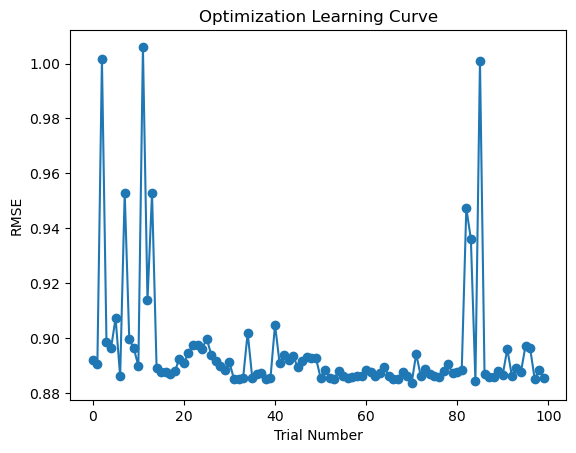

In [176]:
plt.plot(trial_numbers, rmse_values, marker='o')
plt.title('Optimization Learning Curve')
plt.xlabel('Trial Number')
plt.ylabel('RMSE')
plt.show()

In [177]:
params = study.best_params
params

{'criterion': 'squared_error', 'min_samples_leaf': 10, 'max_features': 2}

In [179]:
rf = RandomForestRegressor(n_estimators=100, **params,n_jobs = 5)
rf.fit(x_train, y_train)
# model name rf

RandomForestRegressor(max_features=2, min_samples_leaf=10, n_jobs=5)

In [194]:
y_pred_rf = rf.predict(x_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)


# columns = ['RMSE', 'R-Squared', 'MAE']
# rows = ['Random Forest']
# results_rf = pd.DataFrame(0.0, columns=columns, index=rows)


# results_rf.iloc[0, 0] = rmse_rf
# results_rf.iloc[0, 1] = r2_rf
# results_rf.iloc[0, 2] = mae_rf

# results = results.append(results_rf)

# results = results.round(3)

# print(results)

                            RMSE  R-Squared    MAE
K-Nearest Neighbors (KNN)  1.019     -0.104  0.809
Random Forest              0.893      0.153  0.710


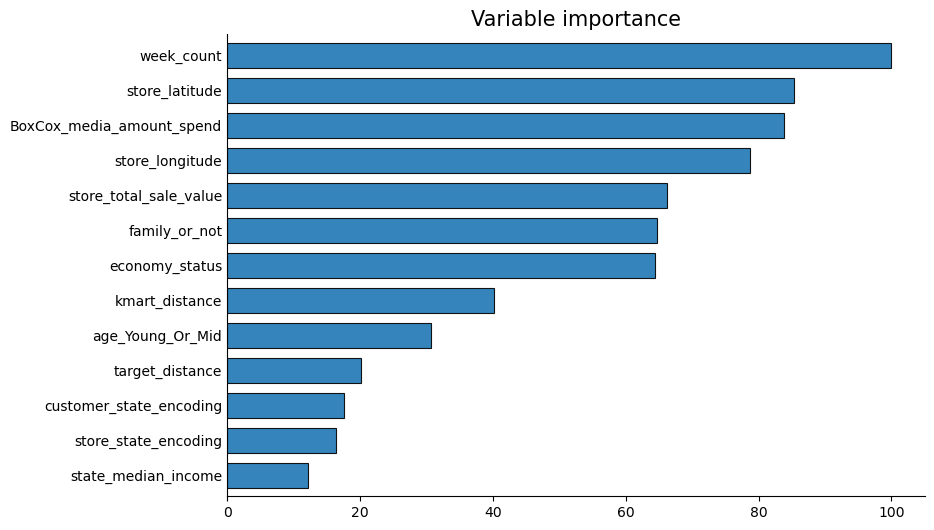

In [181]:
feature_list = list(x_train.columns)
def plot_feature_importance(model, labels, max_features = 13):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=15)
    sns.despine()
    return fig, ax

plot_feature_importance(rf,feature_list)
plt.show()

# XGBoost

In [182]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

x_subsample_xgb, _, y_subsample_xgb, _ = train_test_split(x_train, y_train, test_size=0.8, random_state=0)

xgbst = xgb.XGBRegressor(learning_rate = 0.1, 
                        max_depth = 6, n_estimators = 100)
param_1 = {'learning_rate': [0.1,0.01,0.05],
                'n_estimators': range(60,220,40),
                'max_depth': range(2,10,1)
}

    
xgb_res = RandomizedSearchCV(estimator = xgbst,
                       param_distributions =param_1,
                       n_jobs = 5,
                       cv=5,
                       scoring='neg_root_mean_squared_error', 
                       verbose = 5, 
                       return_train_score = True,
                       random_state = 0
 )

xgb_res.fit(x_subsample_xgb, y_subsample_xgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_jobs=5,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': range(2, 10),
                                        'n_estimators': range(60, 220, 40)},
                   random_state=0, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=5)

In [183]:
xgb_params = xgb_res.best_params_
best_rmse = -xgb_res.best_score_
print("Best hyperparameters:", xgb_res.best_params_)
print("Best RMSE:", best_rmse)

Best hyperparameters: {'n_estimators': 140, 'max_depth': 8, 'learning_rate': 0.1}
Best RMSE: 0.8736790185231126


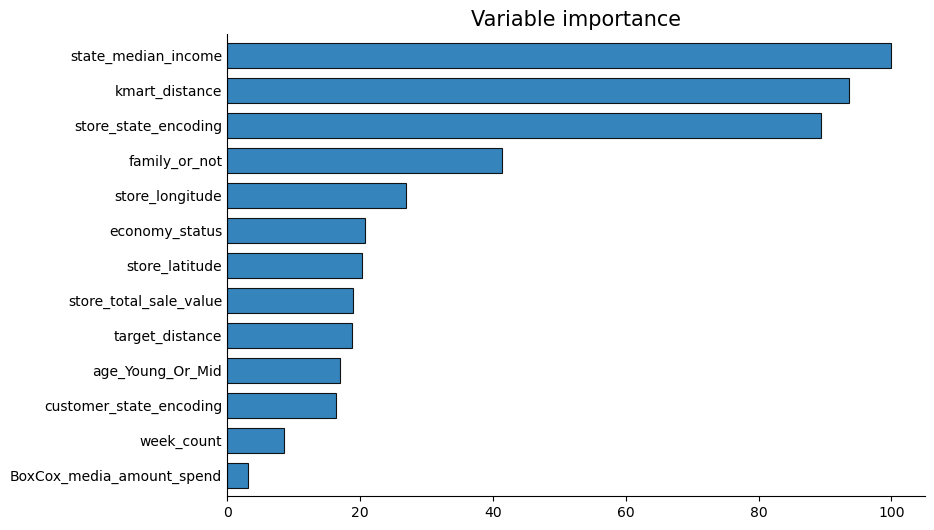

[CV 3/5] END learning_rate=0.1, max_depth=8, n_estimators=140;, score=(train=-0.853, test=-0.869) total time= 1.4min
[CV 1/5] END learning_rate=0.05, max_depth=7, n_estimators=60;, score=(train=-0.935, test=-0.936) total time=  31.7s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=140;, score=(train=-0.908, test=-0.905) total time=  19.5s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=180;, score=(train=-1.379, test=-1.379) total time= 1.6min
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=60;, score=(train=-0.969, test=-0.967) total time=  12.4s
[CV 1/5] END learning_rate=0.05, max_depth=6, n_estimators=100;, score=(train=-0.886, test=-0.885) total time=  46.9s
[CV 1/5] END learning_rate=0.1, max_depth=6, n_estimators=60;, score=(train=-0.882, test=-0.881) total time=  28.8s
[CV 1/5] END learning_rate=0.05, max_depth=5, n_estimators=140;, score=(train=-0.887, test=-0.885) total time=  51.4s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=140

In [184]:
xgbst = xgb.XGBRegressor(**xgb_params,n_jobs = 5)
xgbst.fit(x_train, y_train)
# model name xgboost
plot_feature_importance(xgbst, labels=list(x_train))
plt.show()

In [196]:
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
y_pred_xgbst = xgbst.predict(x_test) 
# columns=['RMSE', 'R-Squared', 'MAE']
# rows=['XGBoost']

# results =pd.DataFrame(0.0, columns=columns, index=rows)
# methods = [knn]
# for i,methods in enumerate(methods): 
#     results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred_xgbst))
#     results.iloc[i, 1] = r2_score(y_test, y_pred_xgbst)
#     results.iloc[i, 2] = mean_absolute_error(y_test, y_pred_xgbst)

# results.round(3)

,RMSE,R-Squared,MAE
XGBoost,0.868,0.2,0.692


# Model Stacking without Neural Network

In [188]:
type(x_train)

pandas.core.frame.DataFrame

In [189]:
type(y_train)

pandas.core.frame.DataFrame

In [190]:
type(x_test)

pandas.core.frame.DataFrame

In [191]:
type(y_test)

pandas.core.frame.DataFrame

In [199]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

kf = KFold(n_splits=5, random_state=42, shuffle=True)

# StackingRegressor with KFold
stack = StackingCVRegressor(regressors=(ols, knn, rf, xgbst),
                            meta_regressor=LinearRegression(),
                            cv=kf)

stack.fit(x_train, y_train)

StackingCVRegressor(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                    meta_regressor=LinearRegression(),
                    regressors=(LinearRegression(),
                                KNeighborsRegressor(metric='mahalanobis',
                                                    metric_params={'VI':                            store_latitude  store_longitude  \
store_latitude               2.706444e+01     4.619069e+00   
store_longitude              4.619069e+00     1.258820e+02   
store_total_sale_value       8.443623e+06    -1.305035e+07...
                                             feature_types=None, gamma=0,
                                             gpu_id=-1, grow_policy='depthwise',
                                             importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.1, max_bin=256,
                                             max_cat_threshold=64,
                                             max_cat_to_onehot=4,
                                             max_delta_step=0, max_depth=8,
                                             max_leaves=0, min_child_weight=1,
                                             missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=140, n_jobs=5,
                                             num_parallel_tree=1,
                                             predictor='auto', random_state=0, ...)))

In [206]:
models = stack.regr_

meta_regressor_coef = stack.meta_regr_.coef_
print("Coefficients of the meta-regressor:")
print(meta_regressor_coef)

Coefficients of the meta-regressor:
[-0.06506527 -0.21373407 -0.34442003  1.59351017]


In [203]:
y_pred_stack = stack.predict(x_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)


# columns = ['RMSE', 'R-Squared', 'MAE']
# rows = ['Model Stack']
# results_stack = pd.DataFrame(0.0, columns=columns, index=rows)

# results_stack.iloc[0, 0] = rmse_stack
# results_stack.iloc[0, 1] = r2_stack
# results_stack.iloc[0, 2] = mae_stack

# results = results.append(results_stack)

# results = results.round(3)

# print(results)

              RMSE  R-Squared    MAE
XGBoost      0.868      0.200  0.692
Model Stack  0.860      0.214  0.688


In [210]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np

results_data = {
    'Model': ['Neural Network', 'Linear Regression', 'K-Nearest Neighbors (KNN)', 'Random Forest', 'XGBoost', 'Model Stack'],
    'RMSE': [test_rmse[1], np.sqrt(mean_squared_error(y_test, y_pred_ols)), np.sqrt(mean_squared_error(y_test, y_pred_knn)), 
             rmse_rf, np.sqrt(mean_squared_error(y_test, y_pred_xgbst)), rmse_stack],
    'R-Squared': [r_squared, r2_score(y_test, y_pred_ols), r2_score(y_test, y_pred_knn), r2_rf, r2_score(y_test, y_pred_xgbst), r2_stack],
    'MAE': [mae, mean_absolute_error(y_test, y_pred_ols), mean_absolute_error(y_test, y_pred_knn), mae_rf, mean_absolute_error(y_test, y_pred_xgbst), mae_stack]
}

results_df = pd.DataFrame(results_data)

print(results_df)

                       Model      RMSE  R-Squared       MAE
0             Neural Network  0.880229   0.176912  0.699897
1          Linear Regression  0.944512   0.052303  0.750874
2  K-Nearest Neighbors (KNN)  1.019444  -0.104032  0.808571
3              Random Forest  0.892974   0.152905  0.710374
4                    XGBoost  0.867667   0.200237  0.692455
5                Model Stack  0.860309   0.213745  0.687644
